In [270]:
%run 00_background.ipynb

#### Example 3 - Hybridization from atom types and degree (no graph conv.)
A property that cannot directly deriven from the atomic symbol is hybridization, since it depends (in general) on the atom and the number of connected atoms (e.g. Carbon with  connections to four other atoms is $sp^3$-hybridized and with three connections usually is $sp^2$-hybridized)

this can be implemented by adding the atom degree (number connected atoms) featurization to the featurizer add in intermediate hidden layer, which combines the atom-type features and the degree, which then results in an output for the hybridization:

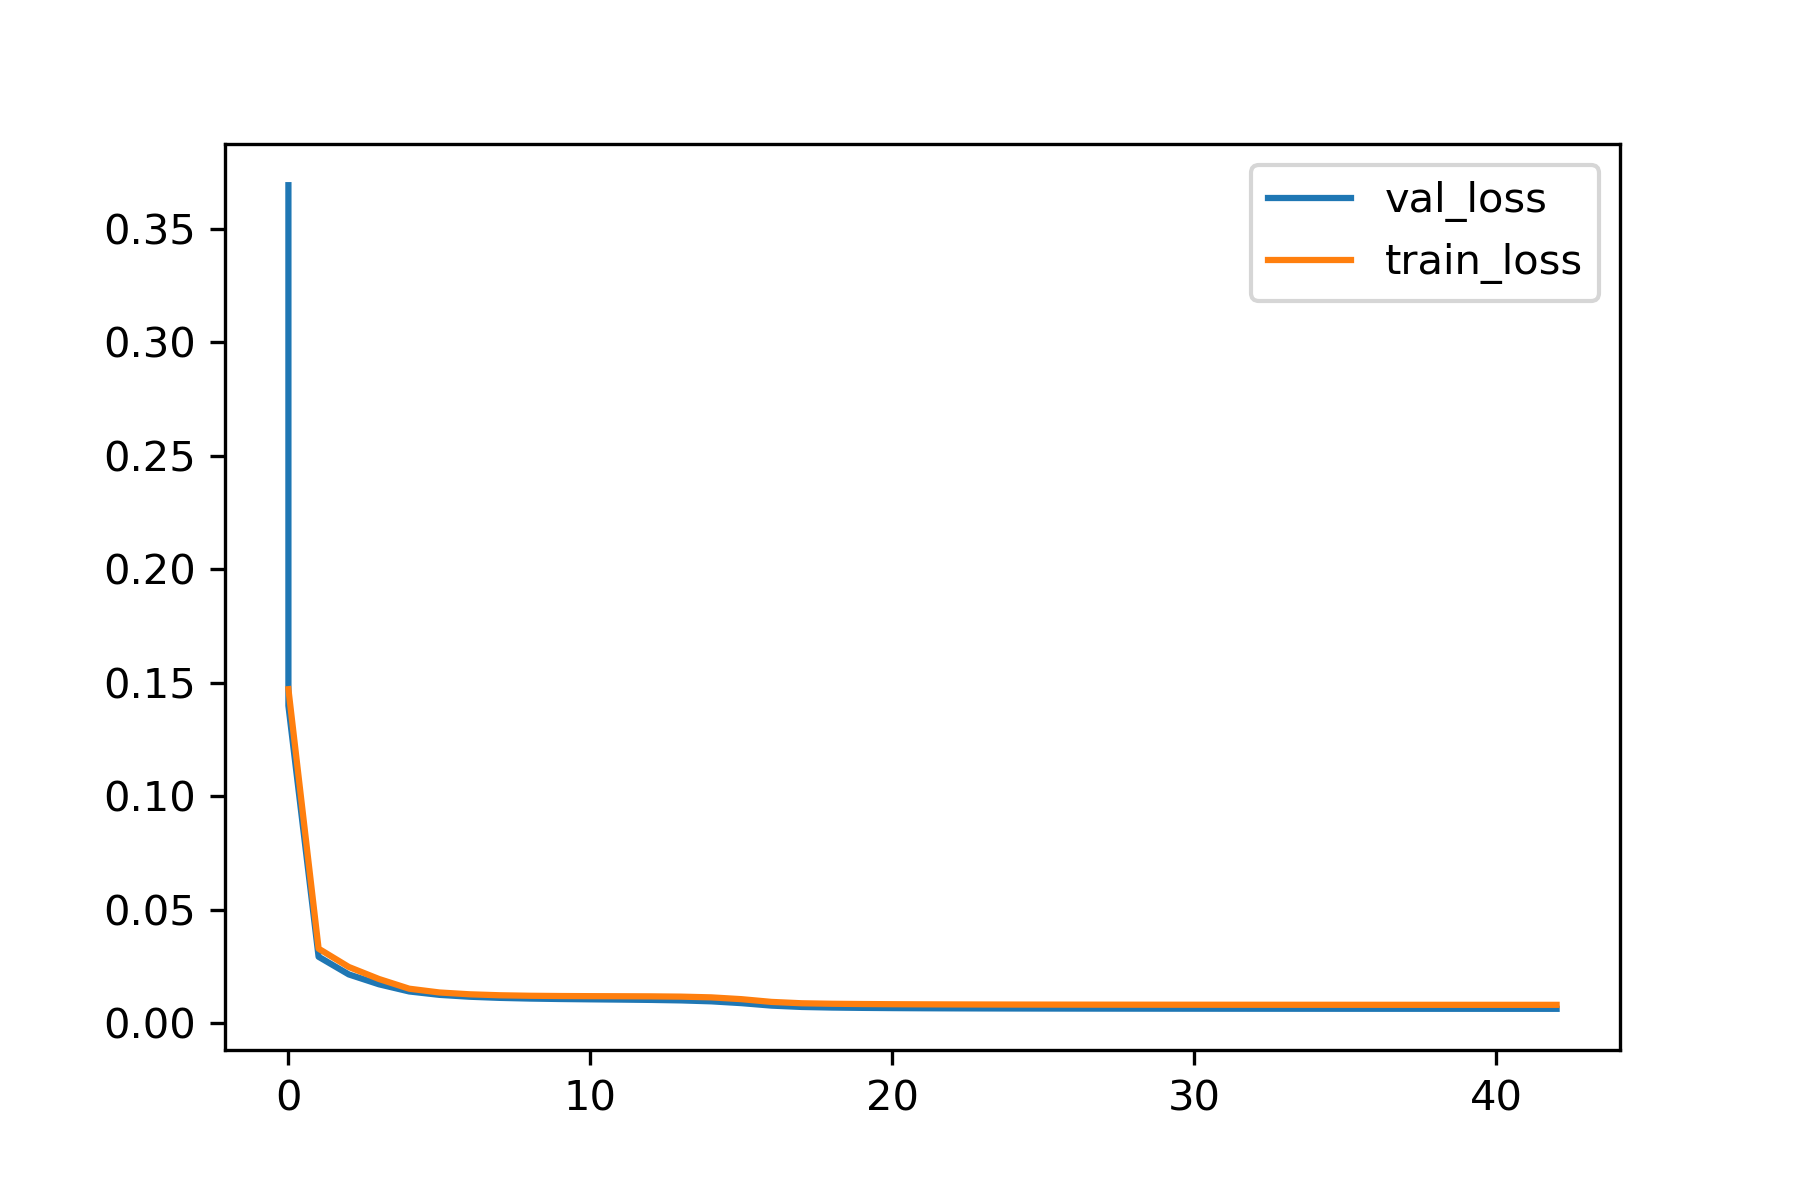

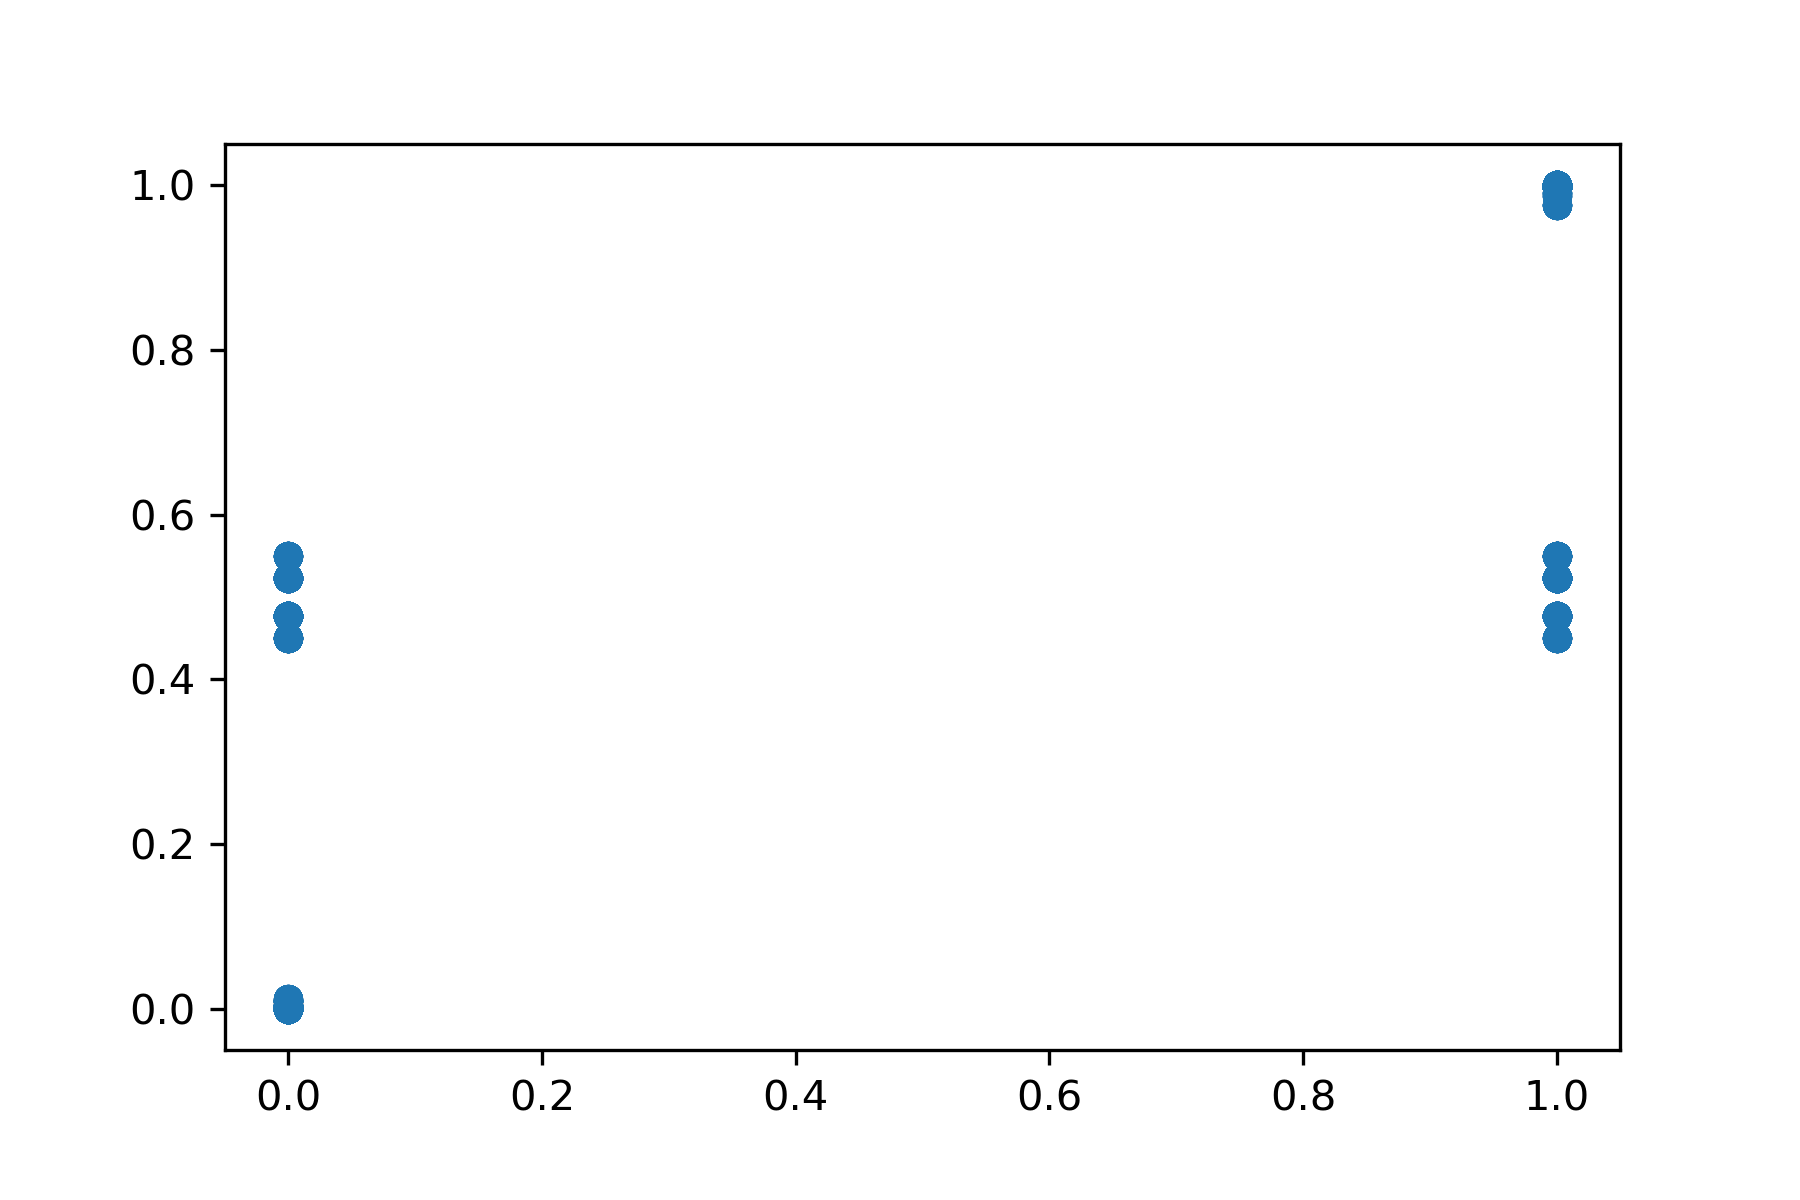

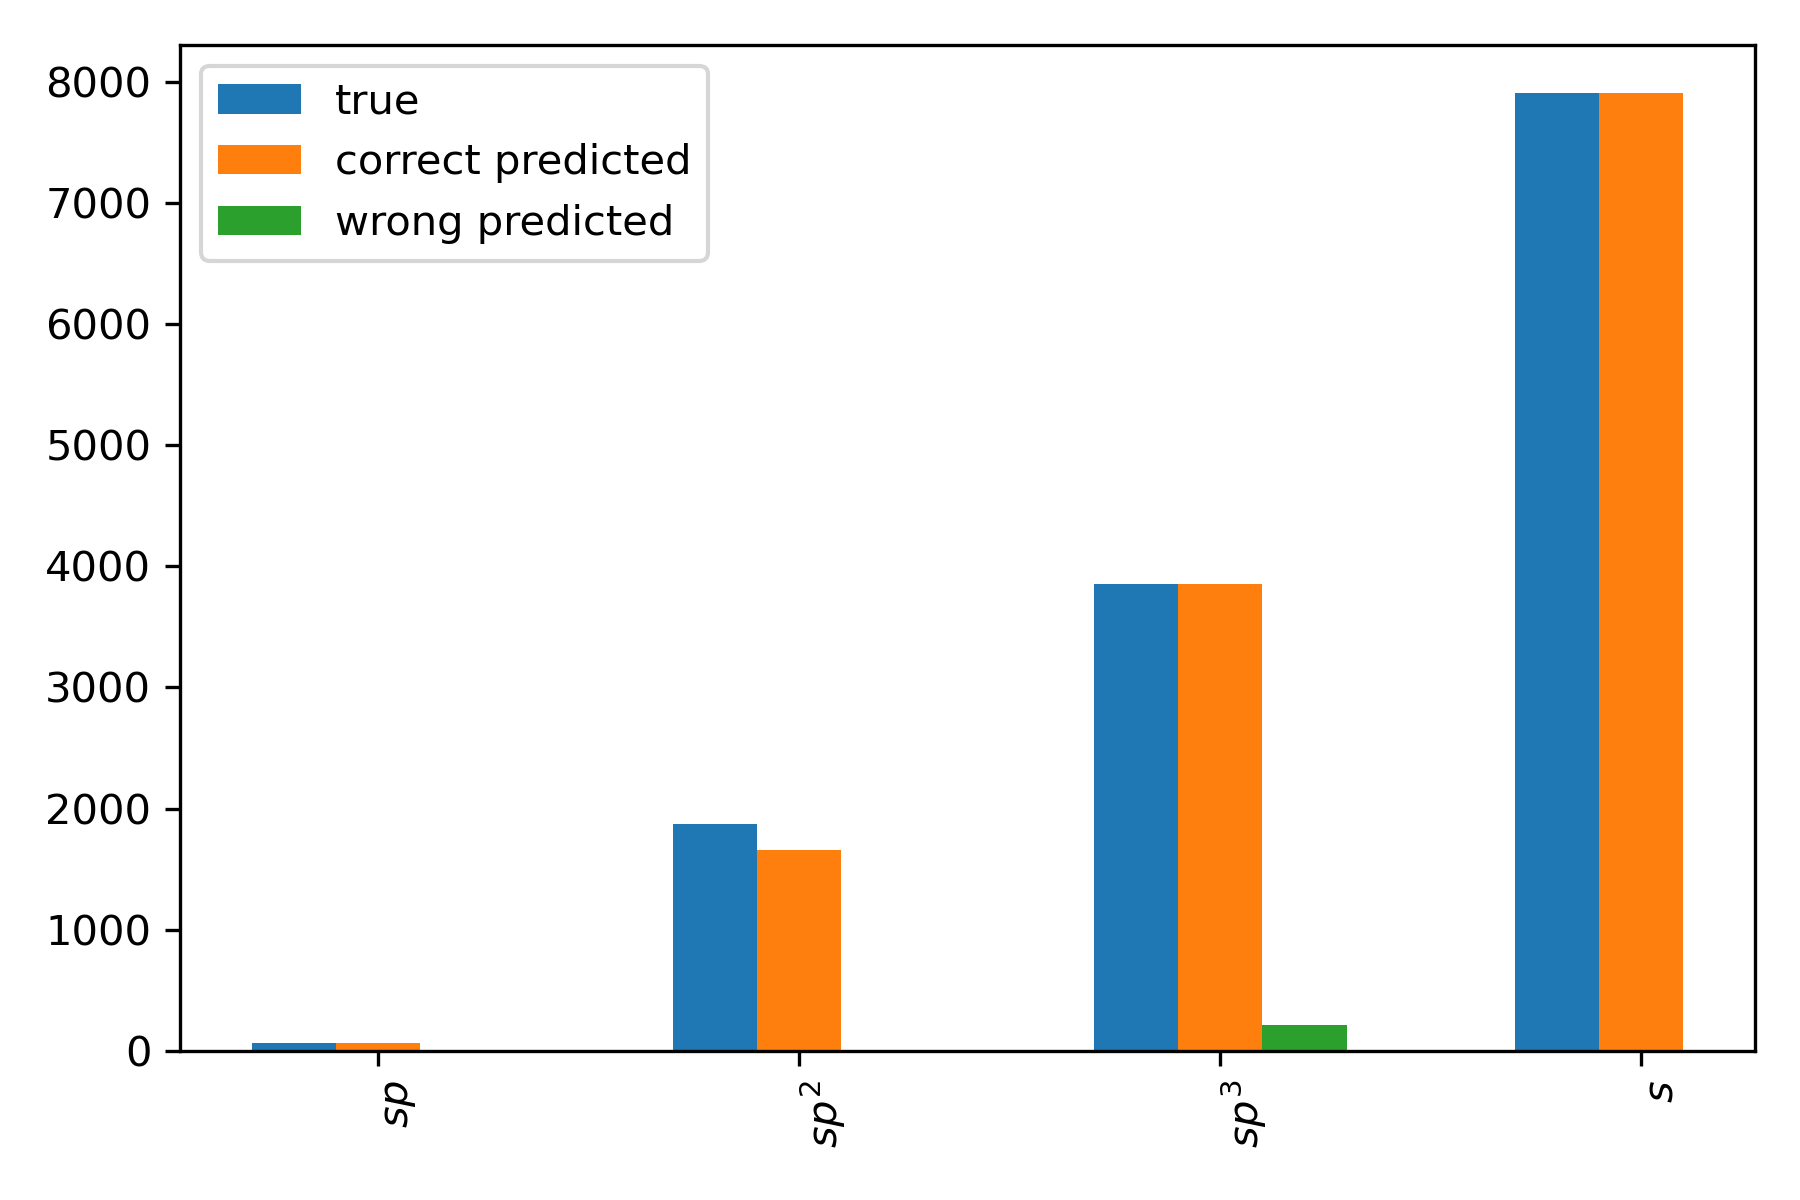

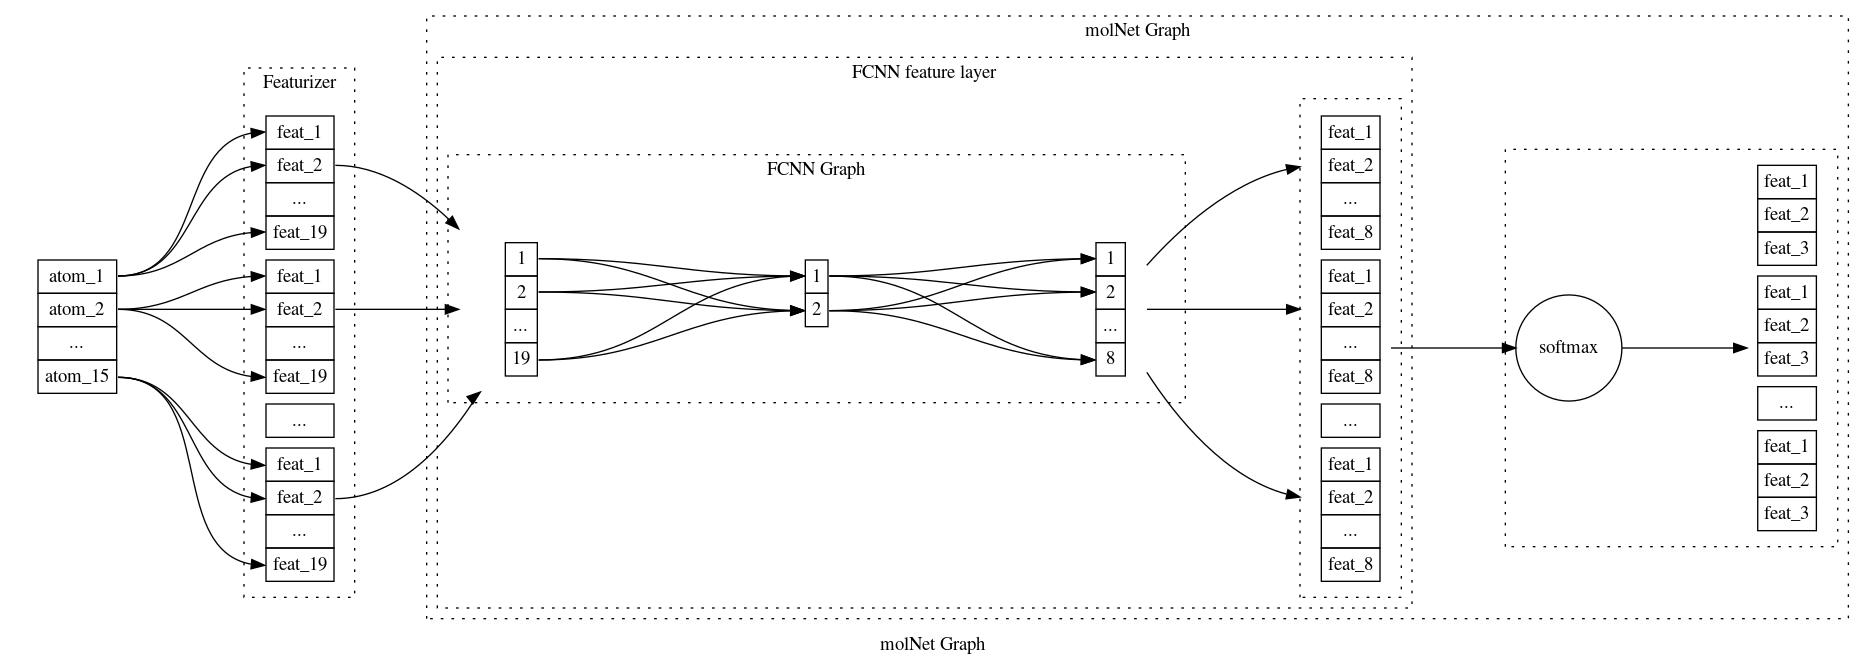

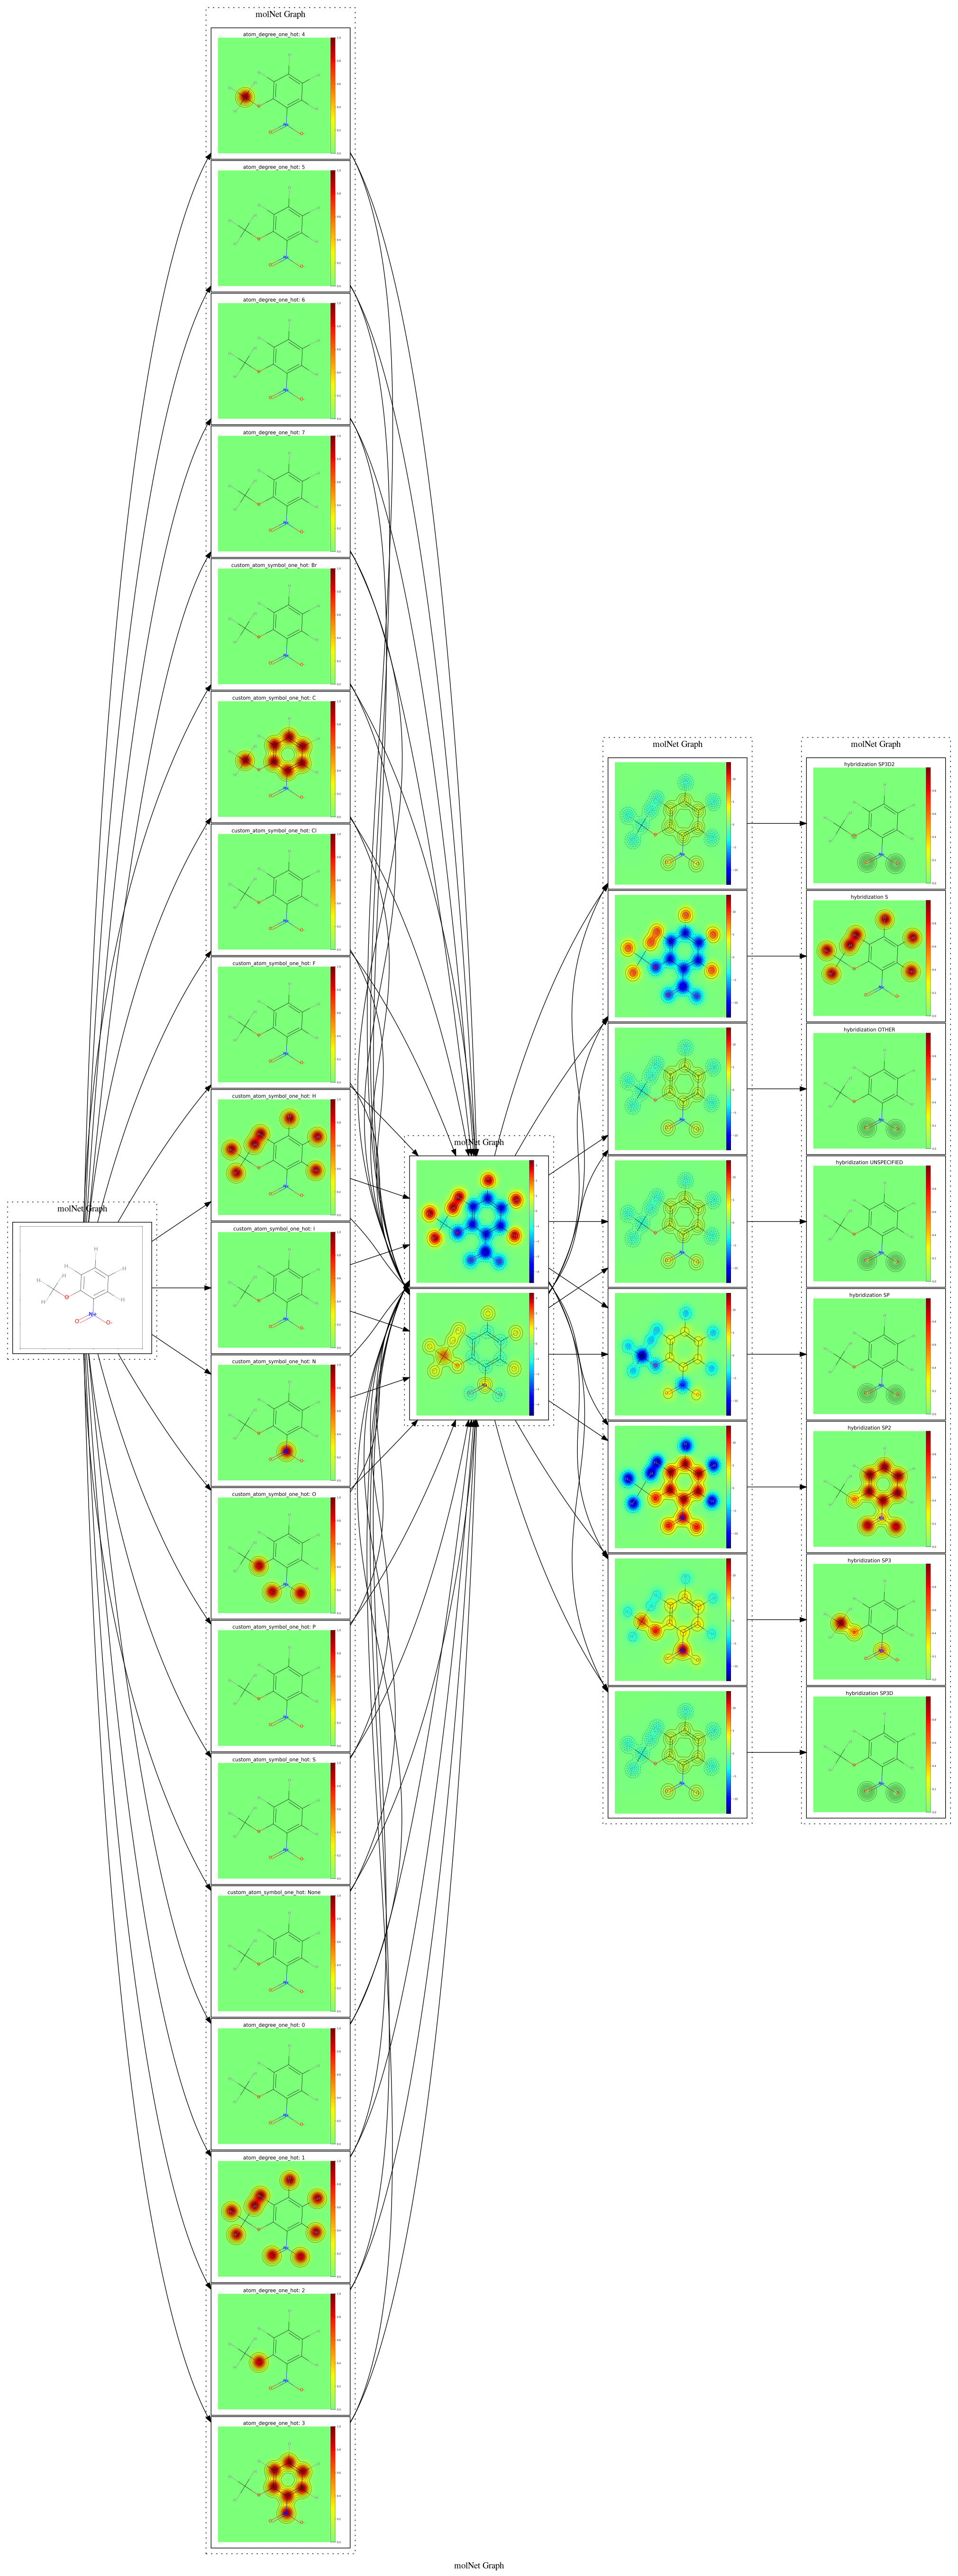

In [273]:
from molNet.featurizer.atom_featurizer import atom_hybridization_one_hot,atom_degree_one_hot

featurizer=c_atom_symbol_featurizer+atom_degree_one_hot
class HybridizationFromTypeAndDegreeModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        out_size=len(atom_hybridization_one_hot)
        
        med_size=2
        
        self.nn1 = torch.nn.Linear(in_size, med_size,bias=False)
        self.nn2 = torch.nn.Linear(med_size, out_size,bias=False)
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.lr = 1e-2
        
        self.lossf=F.binary_cross_entropy#torch.nn.BCEWithLogitsLoss()#

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats =self.nn1(feats)
        feats =self.nn2(feats)
        feats = self.softmax(feats)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        #print(y_hat[0],batch.y[0],loss)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('test_loss', loss)
        return loss
    
    def to_graphviz(self,feature_graph,reduced,name):
        parent=molNetGraphviz(name=name,reduced=reduced)
        nng = FeatureNNCombiGraph(feature_graph,
                                  n_output=self.nn2.out_features,
                                  hidden_layer=[self.nn1.out_features],
                       name=name+"_nn"
                       )
        
        parent.subgraph(nng)
        
        nng_sm=FeatureGraph(frn.feature_graph.features,frn.feature_graph.items,
                   parent=frn.feature_graph, name=name+"_sm")
        parent.subgraph(nng_sm)

        sm = FunctionCall("softmax",nng.feature_graph.node_name,nng_sm.node_name,name=name+"_sm",)
        parent.subgraph(sm)

        parent.output=nng_sm
        
        return parent
    
    def to_graphviz_images_from_batch(self,batch,path,name=None):
        if name is None:
            name=self.__class__.__name__
        parent=molNetGraphviz(name=name,reduced=False)
        parent.attr(nodesep="0", ranksep="1.3")
        
        rdkit.Chem.Draw.MolToMPL(batch.mol_graph[0].mol)
        _atom_ip_img = os.path.join(path,name+"_atom_ip.png")
        plt.savefig(_atom_ip_img,dpi=DEFAULT_DPI, bbox_inches = 'tight')
        plt.close()
        ip = molNetGraphviz(name=name+"_ip",parent=parent)
        ipn=name+"_ip_node"
        ip.node(ipn,table_node([[(0,"")]],image=_atom_ip_img)
               )        
        parent.subgraph(ip)
        
        feats=batch.to_data_list()[0].x
        
    
        fg_img=plot_features_to_mol(feats.detach().numpy(),batch.mol_graph[0].mol,batch.to_data_list()[0].atom_featurizer.describe_features(),
                            plot=False,
                             path=path,
                             prefix=" fg_"
                            )
        
        fg = molNetGraphviz(parent=aig,name=name+"featurize",)
        fg_names=[]
        for i,fgi in enumerate(fg_img):
            nn="{}_fg_node_{}".format(name,i)
            fg_names.append(nn)
            fg.node(nn,table_node([[(0,"")]],image=fgi)
               )  
            fg.edge(ipn,nn)
        parent.subgraph(fg)
        
        feats =self.nn1(feats)
        nn1_img=plot_features_to_mol(feats.detach().numpy(),batch.mol_graph[0].mol,
                            plot=False,
                             path=path,
                             prefix=" nn1_"
                            )
        
        nn1 = molNetGraphviz(parent=aig,name=name+"nn1",)
        nn1_names=[]
        for i,nn1i in enumerate(nn1_img):
            nn="{}_nn1_{}".format(name,i)
            nn1_names.append(nn)
            nn1.node(nn,table_node([[(0,"")]],image=nn1i)
               )  
            for fn in fg_names:
                nn1.edge(fn,nn)
        parent.subgraph(nn1)
        
        feats =self.nn2(feats)
        nn2_img=plot_features_to_mol(feats.detach().numpy(),batch.mol_graph[0].mol,
                            plot=False,
                             path=path,
                             prefix=" nn2_"
                            )
        
        nn2 = molNetGraphviz(parent=aig,name=name+"nn2",)
        nn2_names=[]
        for i,nn2i in enumerate(nn2_img):
            nn="{}_nn2_{}".format(name,i)
            nn2_names.append(nn)
            nn2.node(nn,table_node([[(0,"")]],image=nn2i)
               )  
            for fn in nn1_names:
                nn2.edge(fn,nn)
        parent.subgraph(nn2)
        
        
        feats = self.softmax(feats)
        
        nn3_img=plot_features_to_mol(feats.detach().numpy(),batch.mol_graph[0].mol,atom_hybridization_one_hot.describe_features(),
                            plot=False,
                             path=path,
                             prefix=" nn3_"
                            )
        
        nn3 = molNetGraphviz(parent=aig,name=name+"nn3",)
        nn3_names=[]
        for i,nn3i in enumerate(nn3_img):
            nn="{}_nn3_{}".format(name,i)
            nn3_names.append(nn)
            nn3.node(nn,table_node([[(0,"")]],image=nn3i)
               )  
            nn3.edge(nn2_names[i],nn)
        parent.subgraph(nn3)
        
        return parent
    
    def to_graphviz_from_batch(self,batch=None,reduced=False,name=None):
        if name is None:
            name=self.__class__.__name__
        if batch is None:
            features=4
            mol=None
        else:
            mol = batch.to_data_list()[0]
            features=mol.x.shape[1]
        
        parent=molNetGraphviz(name=name)
        parent.attr(nodesep="0", ranksep="1.3")


        aig = AtomInputGraph(name=name+"_atom_ip",reduced=True)
        parent.subgraph(aig)
        fg = FeaturizerGraph(aig,features,name=name+"_featurize")
        parent.subgraph(fg)
        
        mg=self.to_graphviz(fg,reduced=reduced,name=name+"_mg")
        parent.subgraph(mg)

        return parent
            
loader_HybridizationFromTypeAndDegreeModel = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                     y_properties=["hybridization"],
                                     seed=1,
                                     to_graph_params={
                                         "atom_featurizer":featurizer,
                                         "with_mol_graph":True
                                     },
                                    batch_size=32,#num_workers=4
                                    follow_batch=["y"]
                                    )
model_HybridizationFromTypeAndDegreeModel = HybridizationFromTypeAndDegreeModel(in_size=len(featurizer))

short_hybrid = np.array(["$"+s.split()[1].lower().replace("2","^2").replace("3","^3")+"$" for s in atom_hybridization_one_hot.describe_features()])


model_HybridizationFromTypeAndDegreeModel,data_HybridizationFromTypeAndDegreeModel = default_model_run(
    "HybridizationFromTypeAndDegreeModel",
    model_HybridizationFromTypeAndDegreeModel,
    loader_HybridizationFromTypeAndDegreeModel,
                  force_run=REMODEL,
                  #force_test_data_reload=True,
                #min_epochs=25,
                               #early_stopping=True,
                               #max_epochs=50,
                               detect_lr=False,
                categories=short_hybrid.tolist(),
)


As can be seen, model predicts the true hybridization correctly for nearly every atom in the test data.
The network that predicts the hybrodiztion from atom type and degree can be representet as:

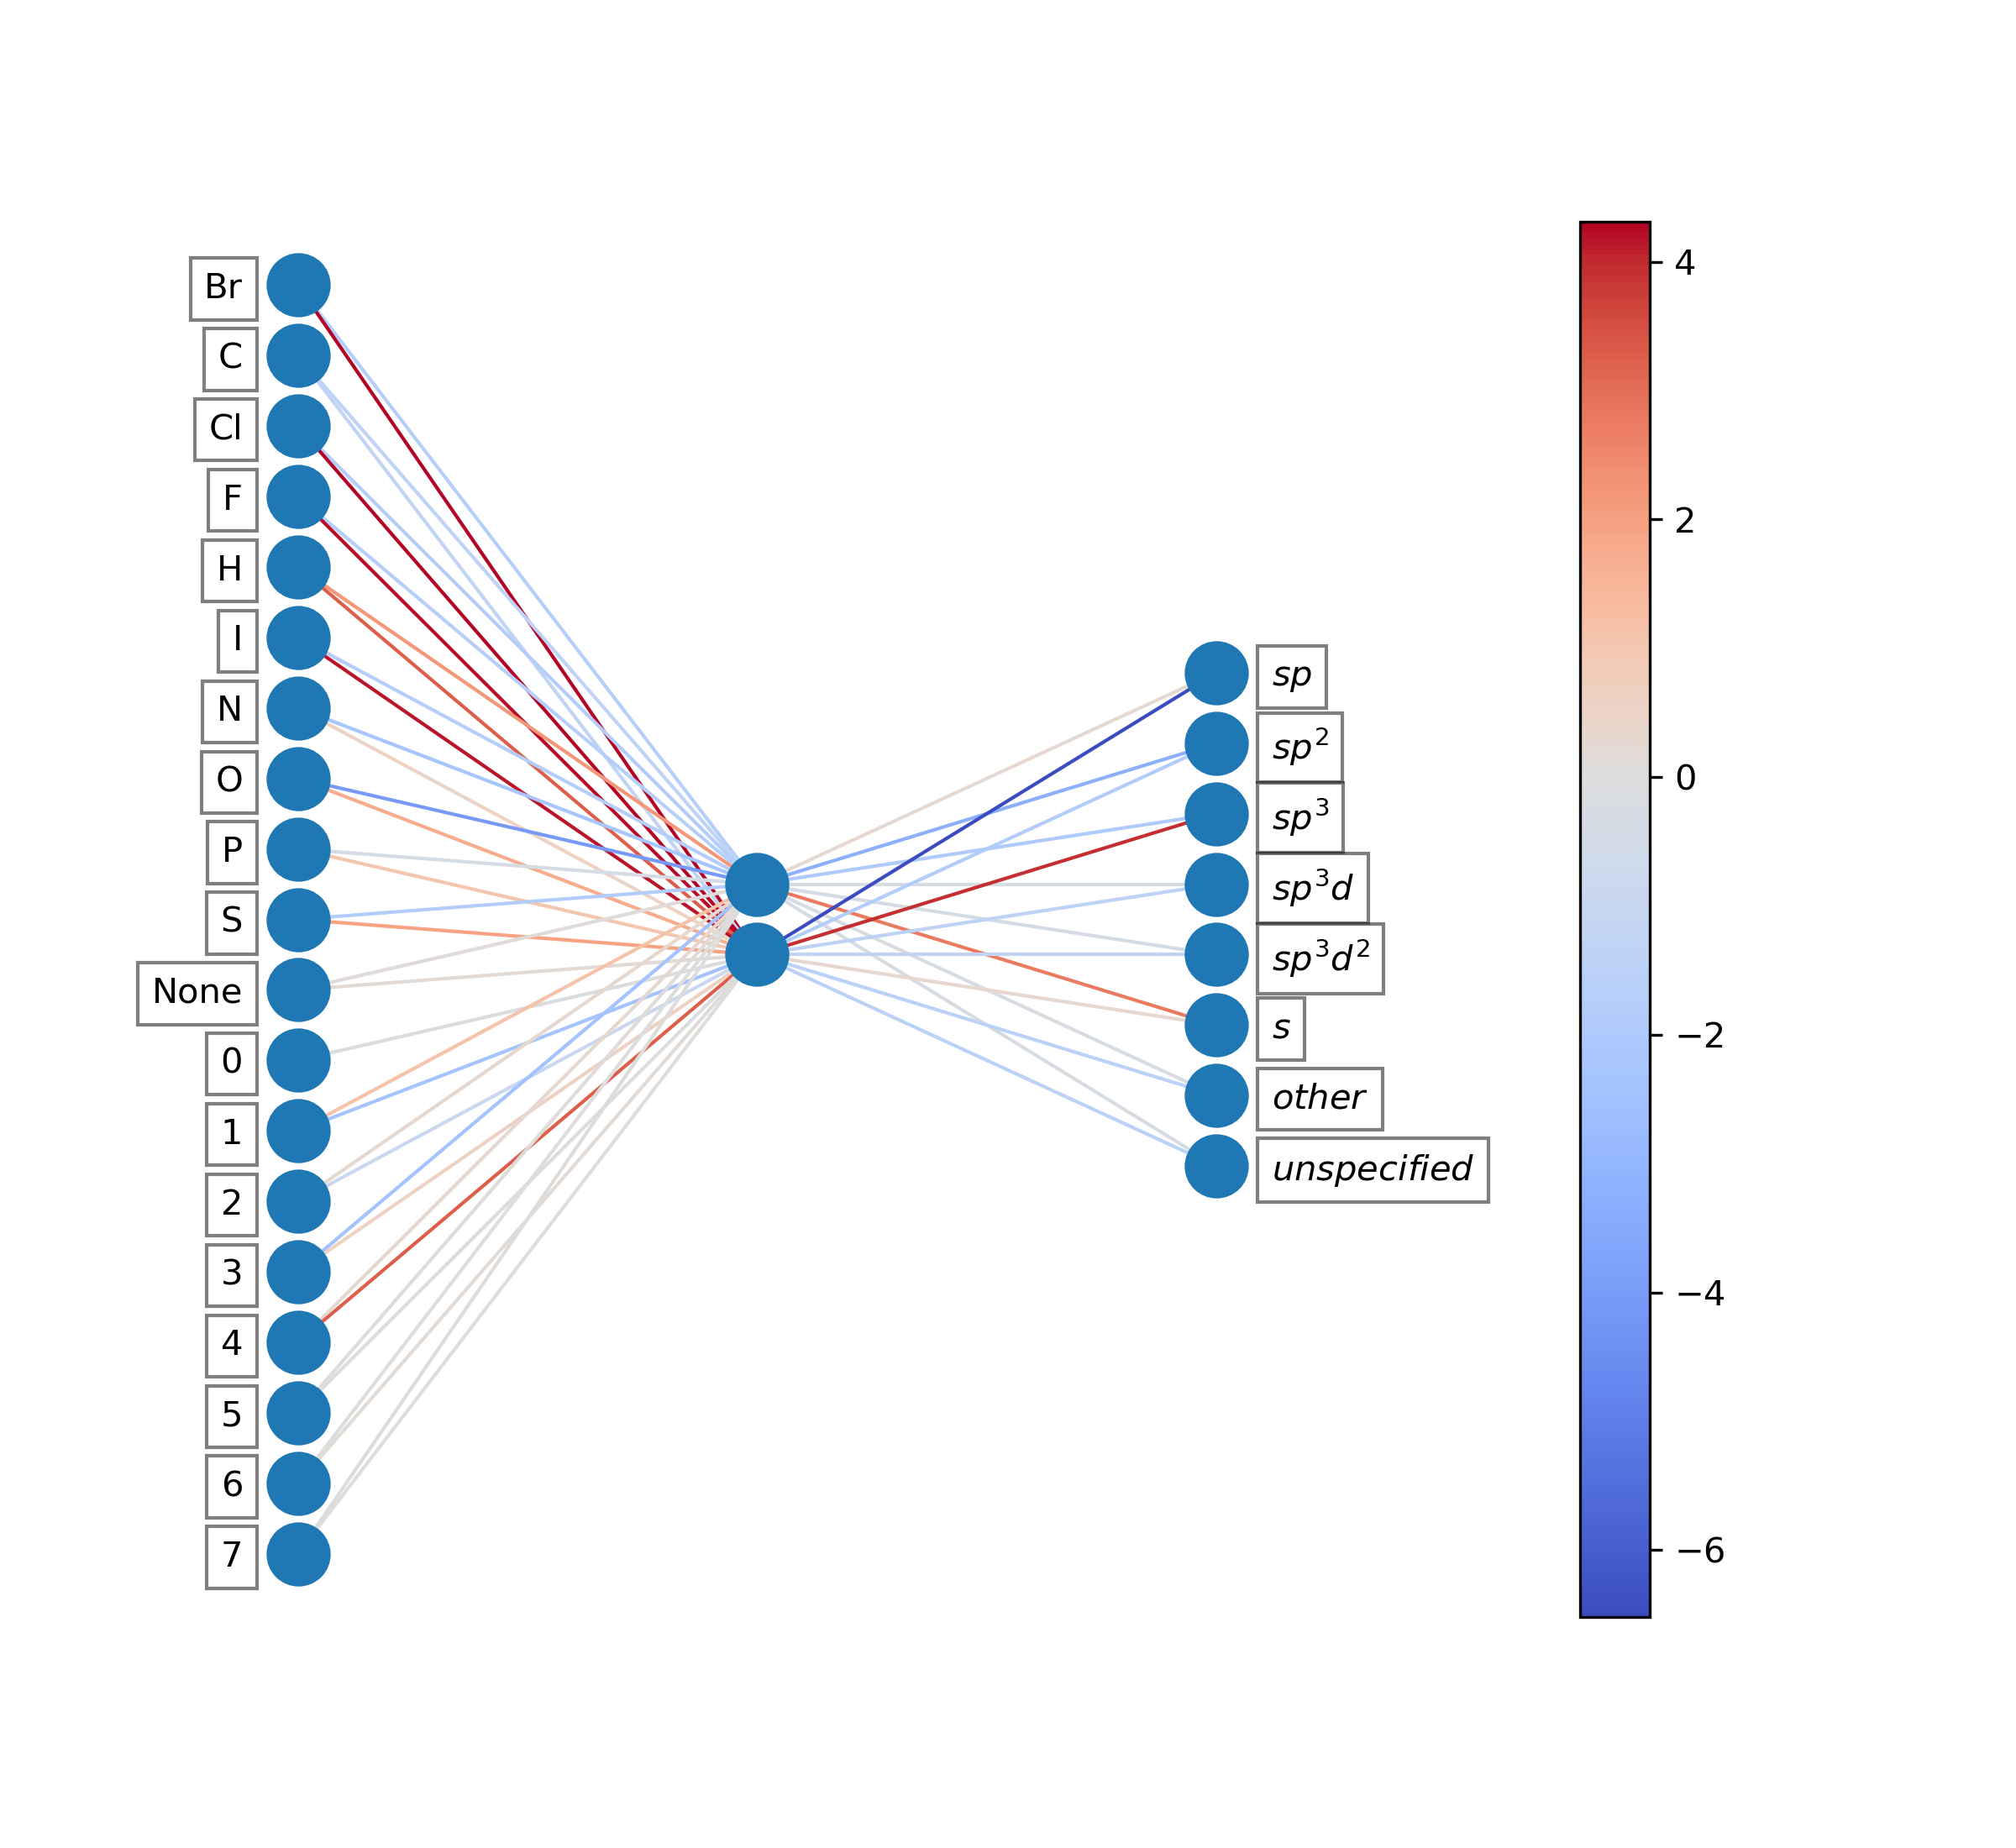

In [245]:
worked=[]
weights1=model_HybridizationFromTypeAndDegreeModel.nn1.weight.detach().numpy().copy()
weights2=model_HybridizationFromTypeAndDegreeModel.nn2.weight.detach().numpy().copy()

sf=os.path.join(data_HybridizationFromTypeAndDegreeModel["files"]['plot_dir'],"full_nn_layer.png")
plot_fcnn([len(loader_HybridizationFromTypeAndDegreeModel.to_graph_params['atom_featurizer']),
           weights1.shape[0],weights2.shape[0]
          ],
          weights=[weights1,weights2],
          input_labels=[s.split(": ")[1] for s in loader_HybridizationFromTypeAndDegreeModel.to_graph_params['atom_featurizer'].describe_features()]+
          [None]*weights1.shape[0]+short_hybrid.tolist(),
              hide_loose=True,
              show_bar=True,
            save=sf,
                 )
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))


even this very small network which is hard to interpret if one looks at the complete structure all at once. It is much easier to look at only the important parts for certain inputs and try to get how the output is created:
For example if we use

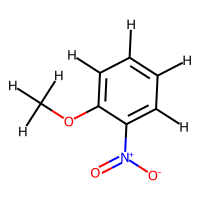

1-Methoxy-2-nitrobenzene

H UNSPECIFIED
O SP2
H UNSPECIFIED
H UNSPECIFIED
O SP2
H UNSPECIFIED
H UNSPECIFIED
H UNSPECIFIED
H UNSPECIFIED
C SP2
N SP2
C SP2
C SP2
C SP2
C SP2
C SP3
O SP2
C SP2


In [246]:
display(data_HybridizationFromTypeAndDegreeModel['test_data'].mol_graph.molecule)
display(md(data_HybridizationFromTypeAndDegreeModel['test_data'].mol_graph.molecule.name))
for atom in data_HybridizationFromTypeAndDegreeModel['test_data'].mol_graph.molecule.mol.GetAtoms():
    print(atom.GetSymbol(),atom.GetHybridization())

As input the resulting prediction can be represented on the molecular graph as:

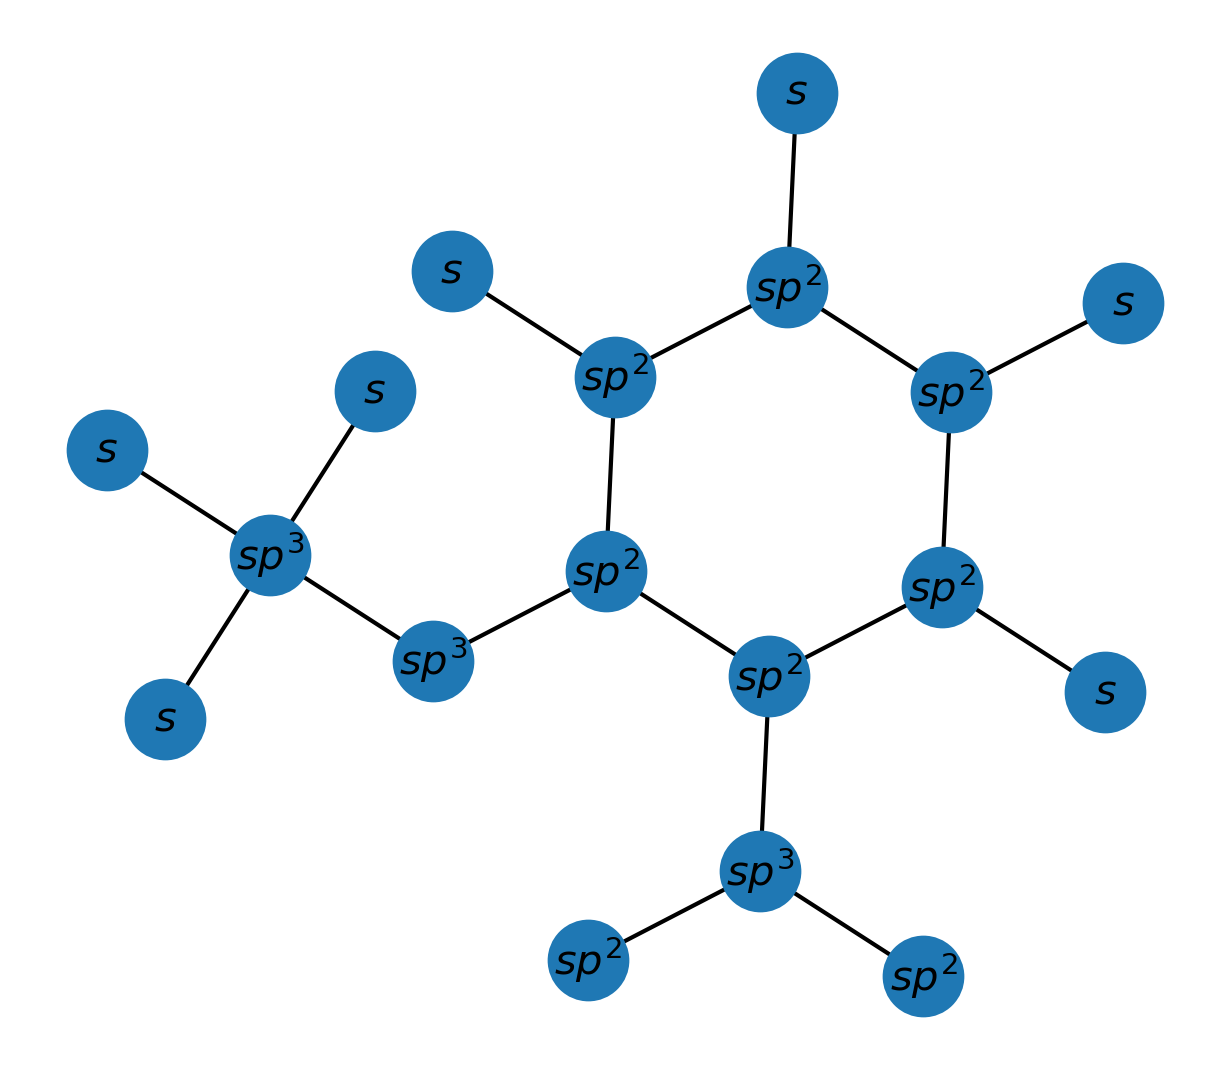

In [247]:
sf=os.path.join(data_HybridizationFromTypeAndDegreeModel["files"]['plot_dir'],"sample_mol_graph_hybridization_pred.png")
if not os.path.exists(sf) or REDRAW:
    l = short_hybrid[model_HybridizationFromTypeAndDegreeModel(data_HybridizationFromTypeAndDegreeModel['test_batch']).detach().numpy().argmax(1)].tolist()
    f = data_HybridizationFromTypeAndDegreeModel['test_data'].mol_graph.get_fig(labels=l)
    plt.savefig(sf,dpi=DEFAULT_DPI)
    plt.close()
    
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))

In [248]:
possible_input_tensors = []
possible_input_arrays = []

for x in data_HybridizationFromTypeAndDegreeModel['test_data'].x:
    x_array=x.detach().numpy()
    if len(possible_input_arrays)>0:
        if any((np.array(possible_input_arrays)[:] == x_array).all(1)):
            continue
    possible_input_tensors.append(x)    
    possible_input_arrays.append(x_array)

feature_desc=np.array(
    [s.split(": ")[1]
     for s in featurizer.describe_features()
    ]
)
so="in this structure all possible combinations of atom time and degree of bonds, and thus all possible input combinations, are:  \n"
for i in range(len(possible_input_arrays)):
    x_array=possible_input_arrays[i].astype(bool)
    atom_desc = feature_desc[x_array]
    so+="- Atom '{}' with {} connected atom  \n".format(atom_desc[0],atom_desc[1])

display(md(so))

in this structure all possible combinations of atom time and degree of bonds, and thus all possible input combinations, are:  
- Atom 'H' with 1 connected atom  
- Atom 'O' with 1 connected atom  
- Atom 'C' with 3 connected atom  
- Atom 'N' with 3 connected atom  
- Atom 'C' with 4 connected atom  
- Atom 'O' with 2 connected atom  


for each if this possible inputs the relevant network structure can be extracted and since it's a much smaller part of the network interpreted much easier

For Atom 'H' with 1 connections

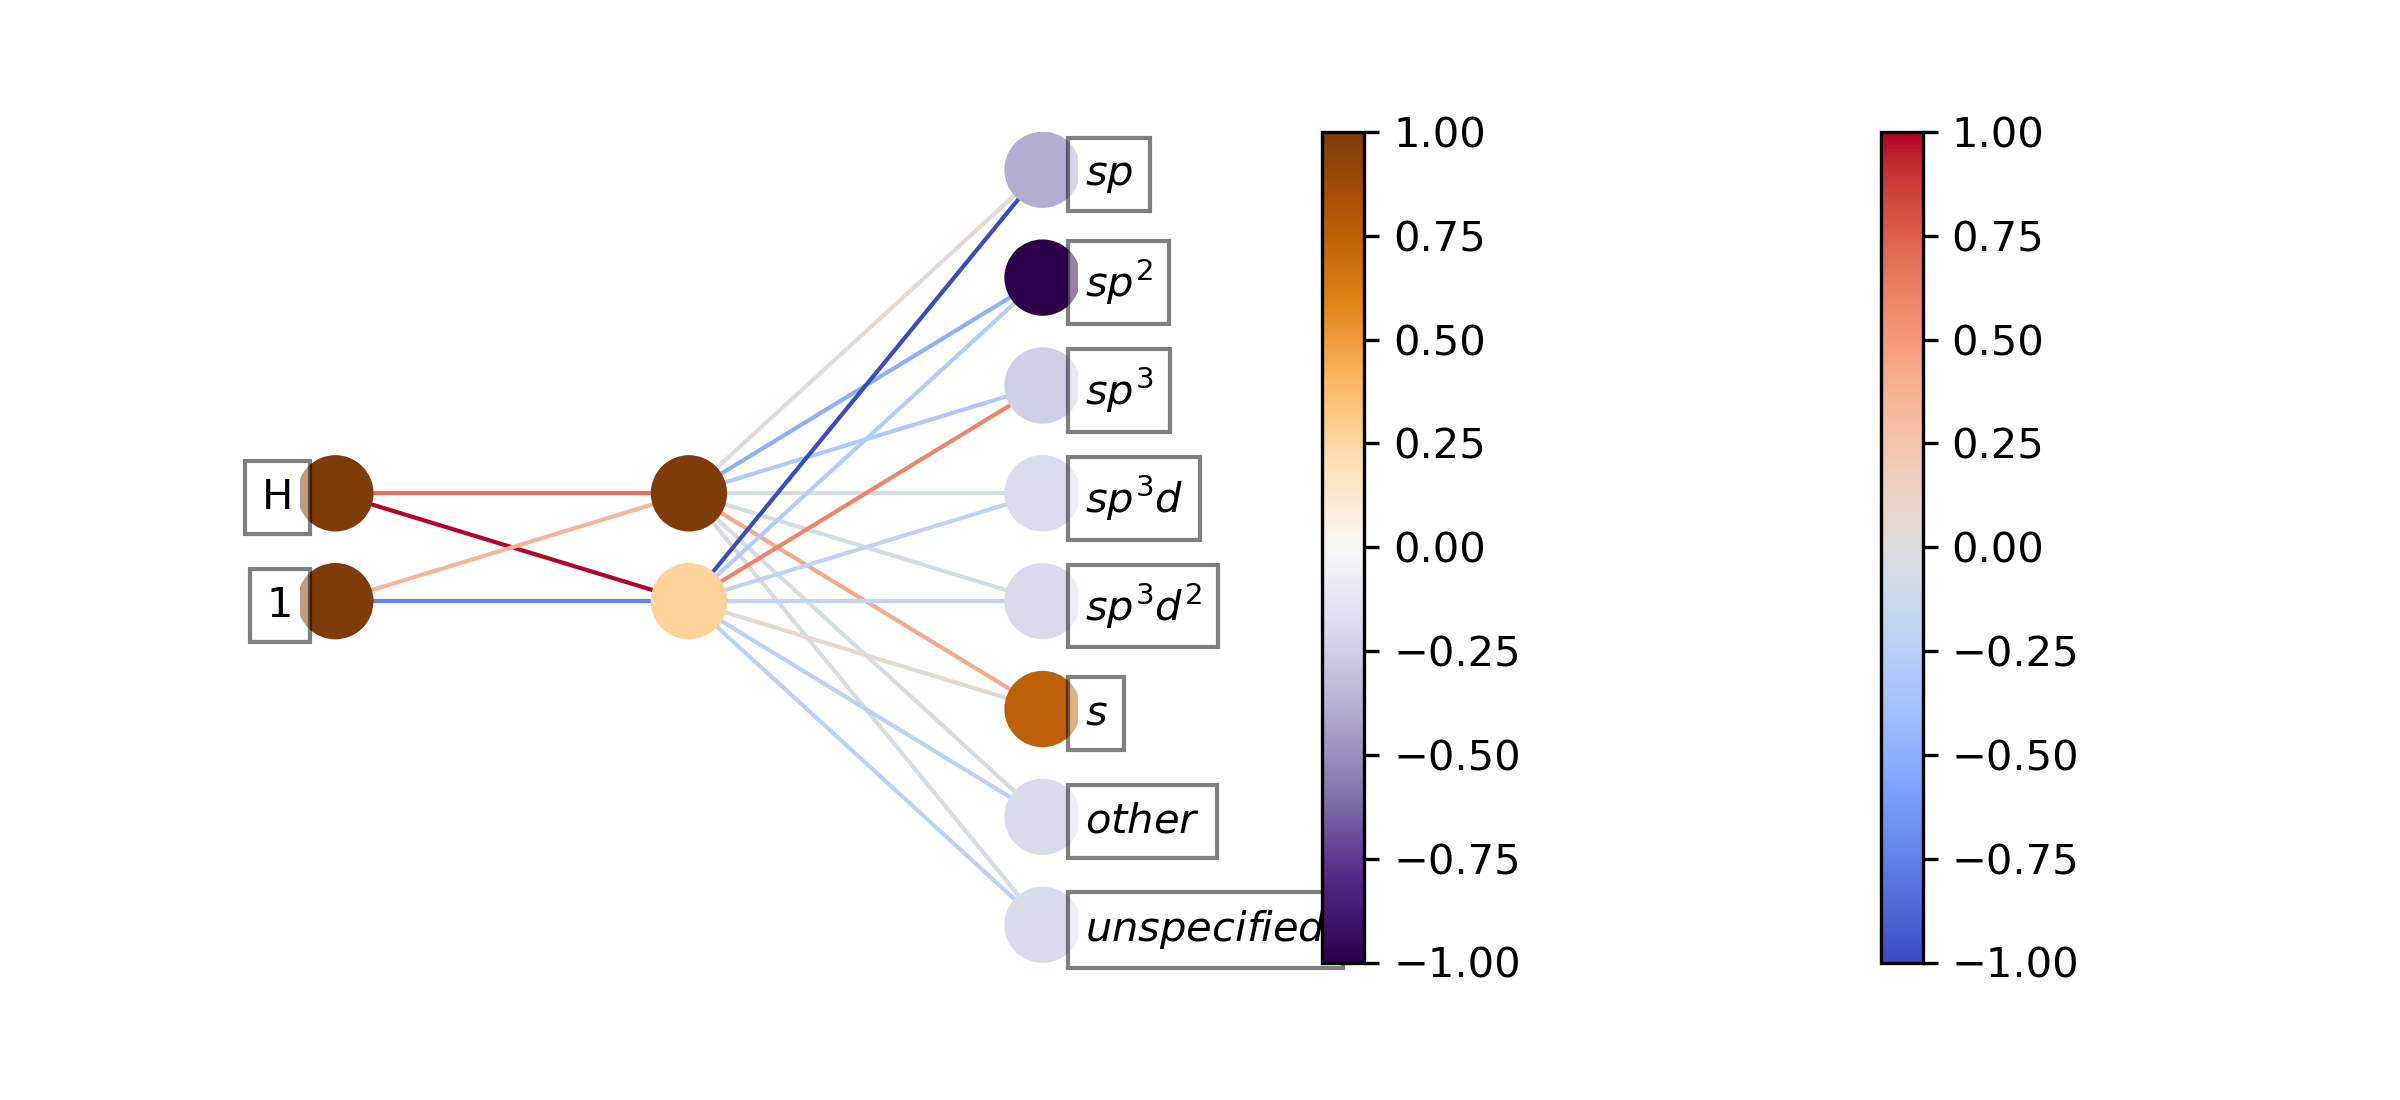

For a hydrogen with a single bond, the result should be $s$, sincethe single $1s$ orbital does not hybridize.
    As can be seen in the network the strongest influence (highest weight) between the input and the hidden layer is beween the
    atom type featuization ('H') and the first hidden neuron. Since the weight is negative the resulting neuron value is also negative.
    The second hidden neuron has a positive value, since both active input neurons are conencted via a positive weight.
    The output node with the highest output value will be the one, which is connected to the first (negative) hidden note with a negive weight
    and with the second hidden note via a positive weight.
    As can be seen in the graph representation, this is indeed the case for the last output noden, wich encodes the $s$ hybridization.
    

For Atom 'O' with 1 connections

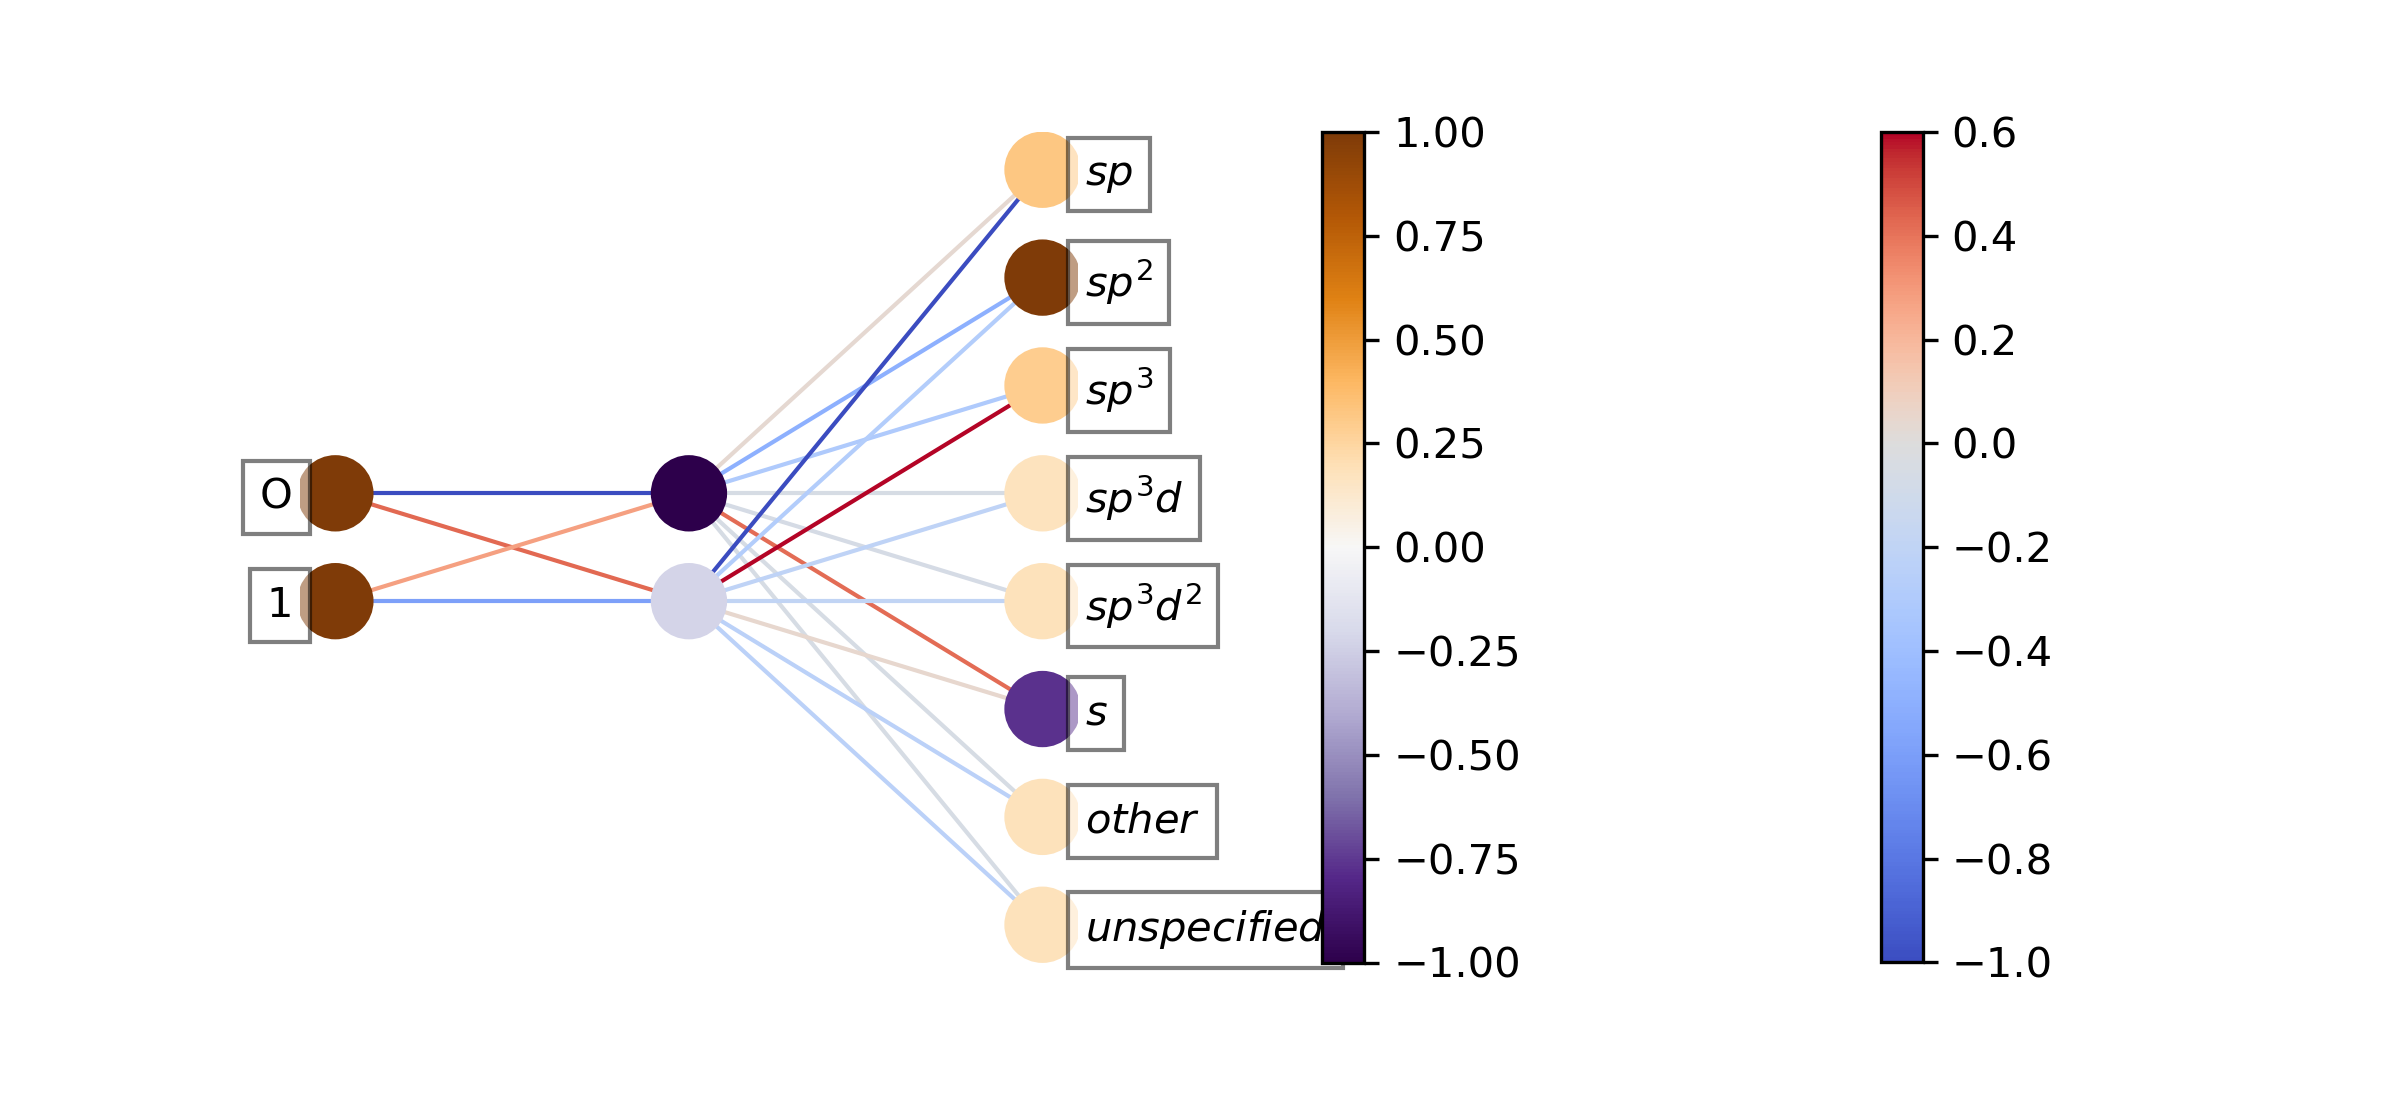

An oxigen atom with a single bonding partners is predicted to be $sp^2$ hybridized.
    This prediction results strong negative weighted connecten between the atom type input and
    the second hidden neuron, and posive weighted connection beween the degree input and the number input, and the first hidden neuron.
    Which results in a similar hidden neurons with opposite signs.
    As a result the output node with the highest value is the one with has a strong posive to the first and a
    strong negative connection to the second hidden node, which is the case for the $sp^2$-output.
    

For Atom 'C' with 3 connections

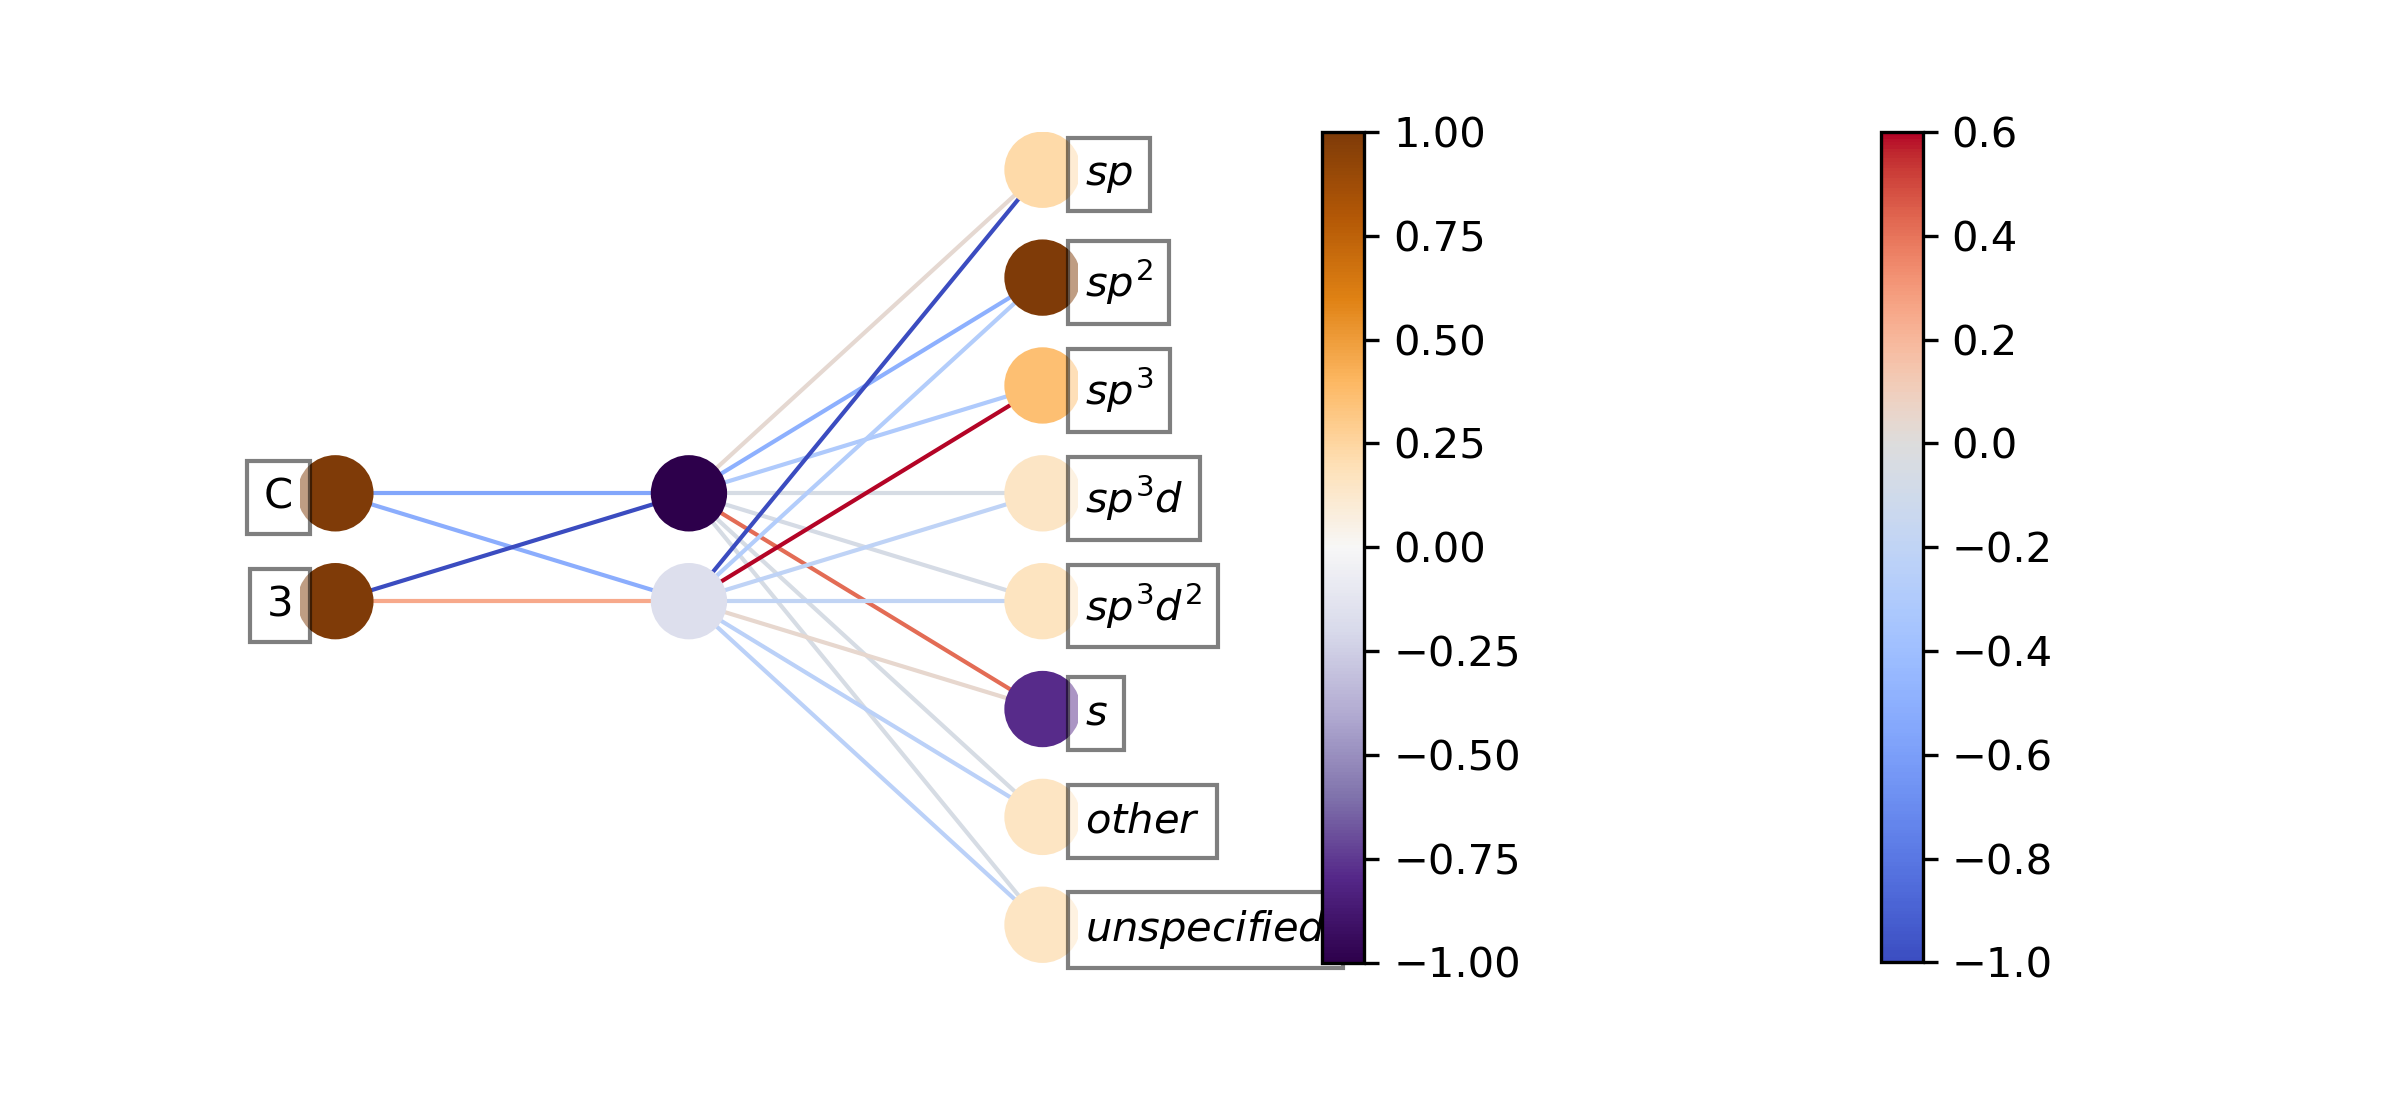

A carbon atom with 3 bonding partners is also predicted to be $sp^2$ hybridized.
    This prediction results from a positive weighted connecten between the atom type input and
    the first hidden neuron, and negative weighted connection beween the degree input and the second hidden neuron.
    Both weights are of similar absolute value, resulting in a similar hidden neurons with opposite signs,
    similar the the previous example, resulting in the same output.
    

For Atom 'N' with 3 connections

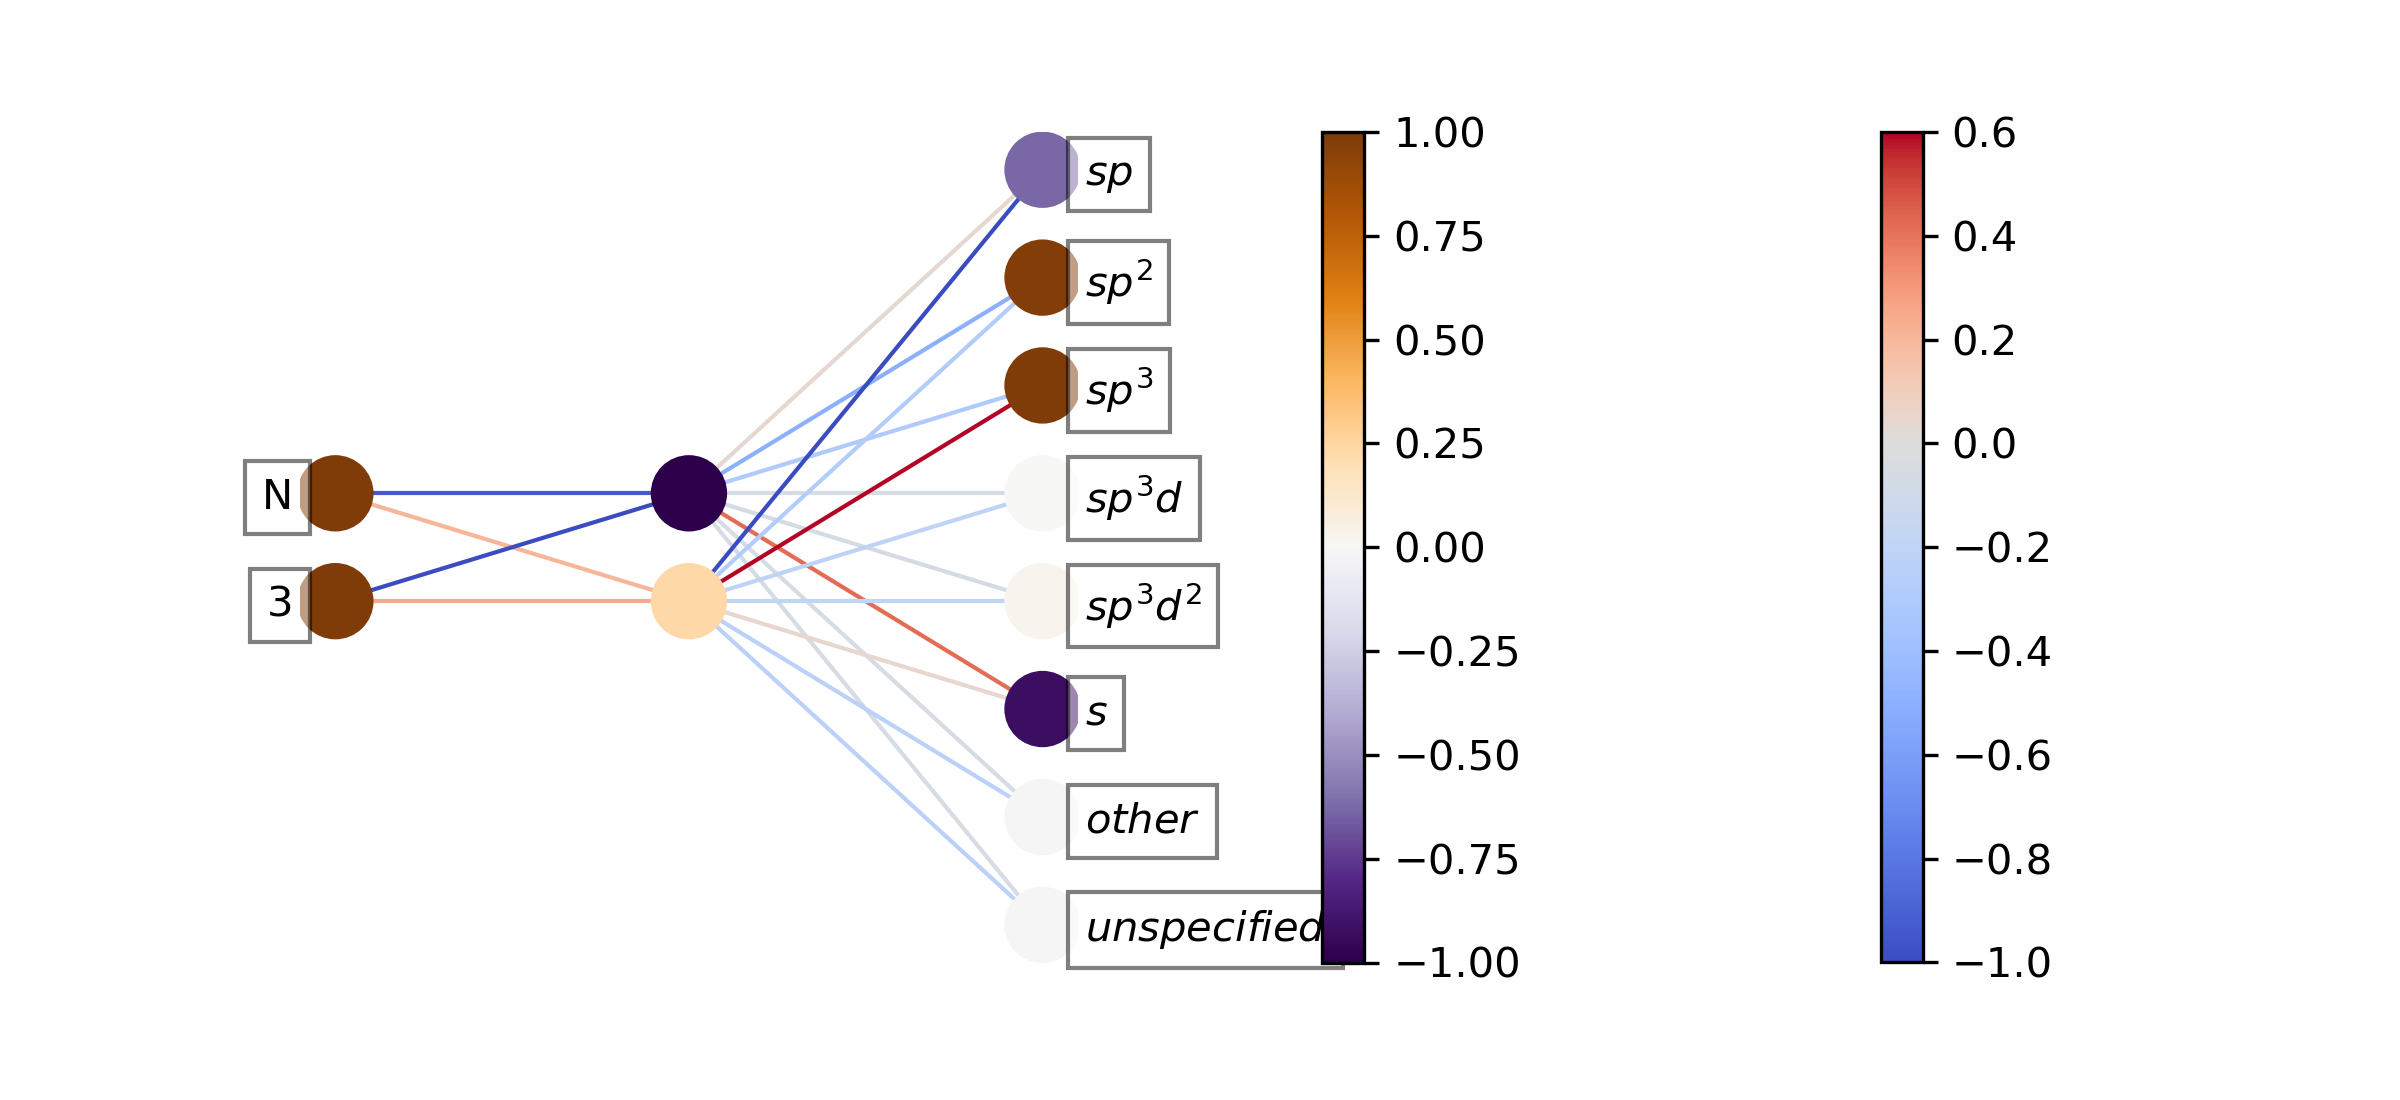

A nitrogen atom with 3 bonding partners is predicted to be $sp^3$ hybridized.
    In contrast to the previous inputs, here both inputs have a strong negative connection to the second hidden 
    neuron and only weak (positive and negative) connections to the fist hidden node.
    As a result the first hidden node is only weakly positive and the second node strogly negative.
    The predicted output will be encoded by the node which has the strongest negative connection to the second hidden node,
    which is indeed the $sp^3$-node. While this is true for in e.g. amines, in this case the hybridization should evaluate to $sp^2$
    since the nitrogen in $R-NO_2$ is planar and has in it's resonaze structures 4 bonds to the 3 neibouring atoms.
    

For Atom 'C' with 4 connections

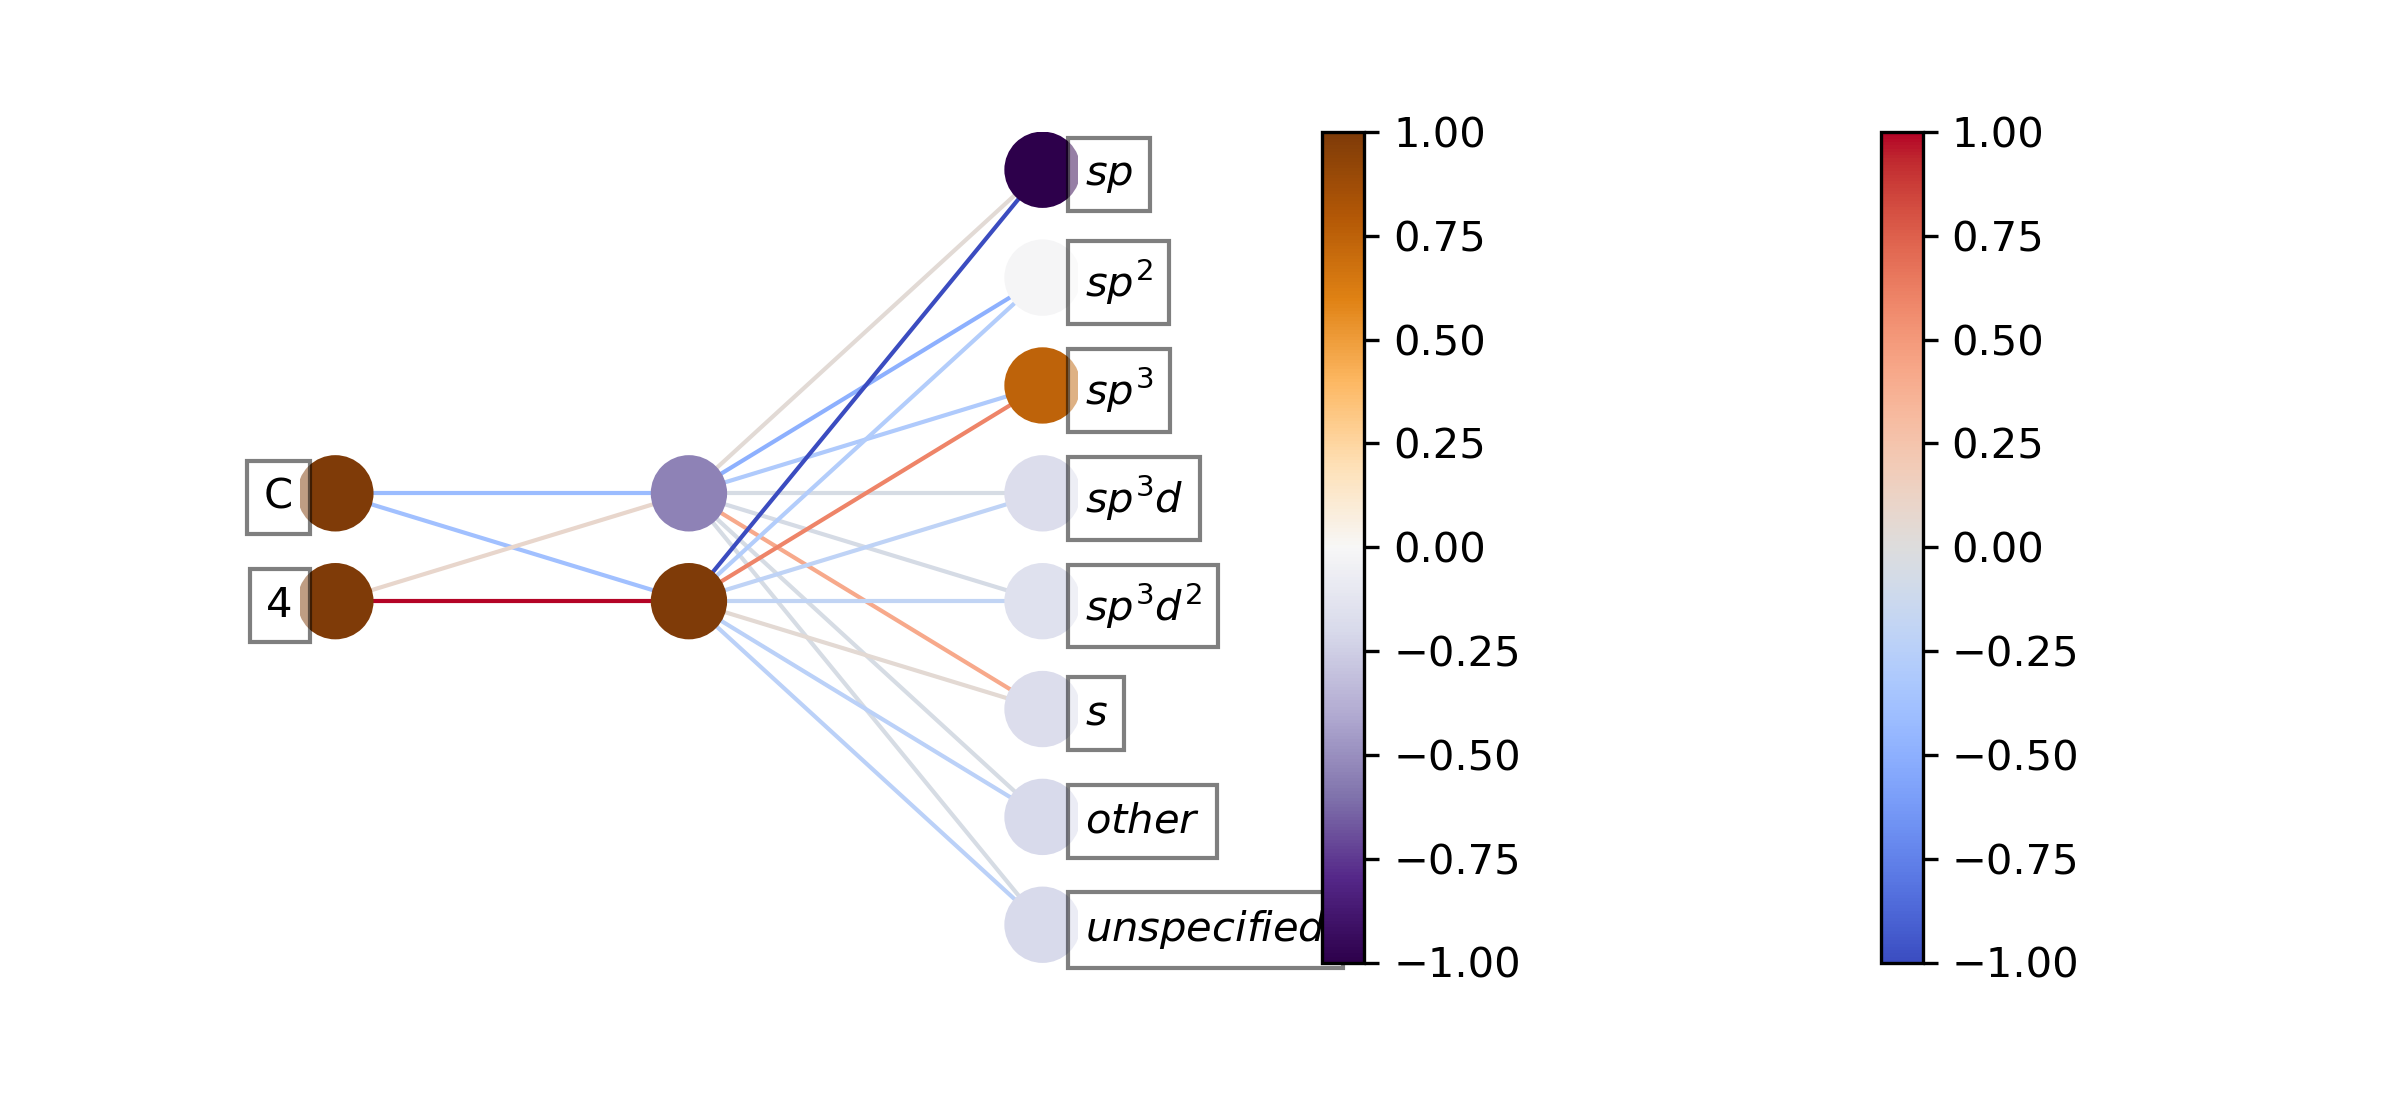

Similary a carbon with 4 bonding partners is also predicted to be $sp^3$ hybridized.
    In this case the atom type input has only a weak influence (low weights),
    but the degree is strongly conencted to both hidden nodes.
    This makes sence, since in organic chemsitry, which makes up the training data, usually atoms with for connections
    (carbon in most cases) is $sp^3$ hybridized.
    Now both hidden neurons have negative values. As a result the output is determinded by
    the most negative conenctions beween hidden neurons and output.
    

For Atom 'O' with 2 connections

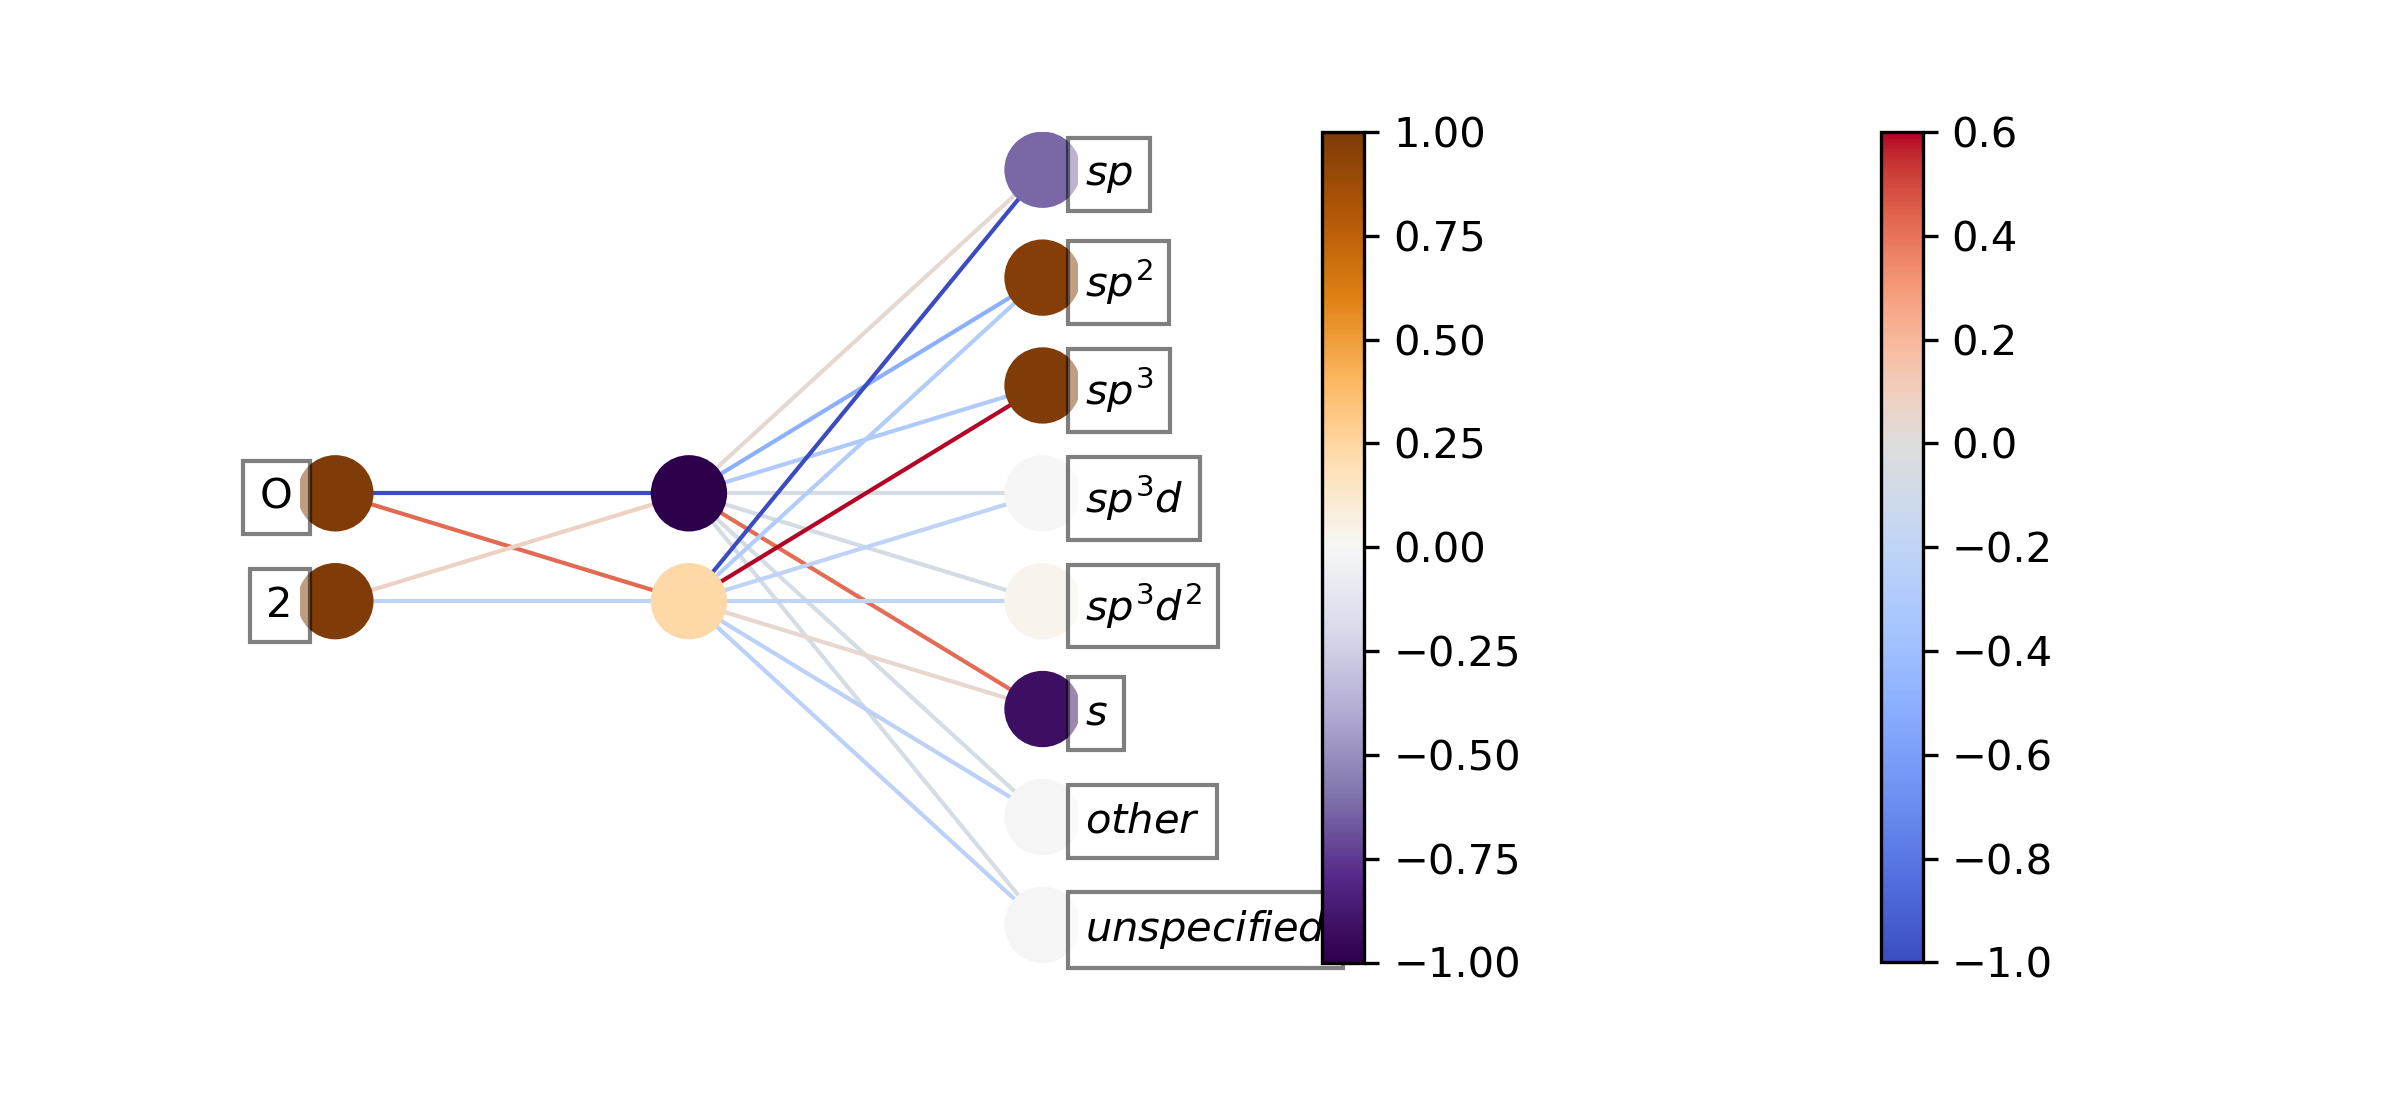

Fnally, oxigen atoms with 2 bonding partners are predicted to be $sp^3$ hybridized.
    This is a result from a strong negative connection from atom type input to second hidden node.
    All other conenctions are relativly weak, resulting again in a similar distribution in values
    in the hidden layers as in the previous $sp^3$ hybridized atoms and thus the same output.
    In this case this prediction is wrong, since one op the $p$-orbitals is integrated into the $\pi$-orbital of the connected phenyl ring.
    But since the model is not aware of any neigbouring atoms or systems, it cannot take into account any delocalization effects.
    

In [249]:
interpretations={
    ('H','1'):
    """For a hydrogen with a single bond, the result should be $s$, sincethe single $1s$ orbital does not hybridize.
    As can be seen in the network the strongest influence (highest weight) between the input and the hidden layer is beween the
    atom type featuization ('H') and the first hidden neuron. Since the weight is negative the resulting neuron value is also negative.
    The second hidden neuron has a positive value, since both active input neurons are conencted via a positive weight.
    The output node with the highest output value will be the one, which is connected to the first (negative) hidden note with a negive weight
    and with the second hidden note via a positive weight.
    As can be seen in the graph representation, this is indeed the case for the last output noden, wich encodes the $s$ hybridization.
    """,
('O','1'):
    """An oxigen atom with a single bonding partners is predicted to be $sp^2$ hybridized.
    This prediction results strong negative weighted connecten between the atom type input and
    the second hidden neuron, and posive weighted connection beween the degree input and the number input, and the first hidden neuron.
    Which results in a similar hidden neurons with opposite signs.
    As a result the output node with the highest value is the one with has a strong posive to the first and a
    strong negative connection to the second hidden node, which is the case for the $sp^2$-output.
    """,
('C','3'):
    """A carbon atom with 3 bonding partners is also predicted to be $sp^2$ hybridized.
    This prediction results from a positive weighted connecten between the atom type input and
    the first hidden neuron, and negative weighted connection beween the degree input and the second hidden neuron.
    Both weights are of similar absolute value, resulting in a similar hidden neurons with opposite signs,
    similar the the previous example, resulting in the same output.
    """,
('N','3'):
    """A nitrogen atom with 3 bonding partners is predicted to be $sp^3$ hybridized.
    In contrast to the previous inputs, here both inputs have a strong negative connection to the second hidden 
    neuron and only weak (positive and negative) connections to the fist hidden node.
    As a result the first hidden node is only weakly positive and the second node strogly negative.
    The predicted output will be encoded by the node which has the strongest negative connection to the second hidden node,
    which is indeed the $sp^3$-node. While this is true for in e.g. amines, in this case the hybridization should evaluate to $sp^2$
    since the nitrogen in $R-NO_2$ is planar and has in it's resonaze structures 4 bonds to the 3 neibouring atoms.
    """,
('C','4'):
    """Similary a carbon with 4 bonding partners is also predicted to be $sp^3$ hybridized.
    In this case the atom type input has only a weak influence (low weights),
    but the degree is strongly conencted to both hidden nodes.
    This makes sence, since in organic chemsitry, which makes up the training data, usually atoms with for connections
    (carbon in most cases) is $sp^3$ hybridized.
    Now both hidden neurons have negative values. As a result the output is determinded by
    the most negative conenctions beween hidden neurons and output.
    """,
('O','2'):
    """Fnally, oxigen atoms with 2 bonding partners are predicted to be $sp^3$ hybridized.
    This is a result from a strong negative connection from atom type input to second hidden node.
    All other conenctions are relativly weak, resulting again in a similar distribution in values
    in the hidden layers as in the previous $sp^3$ hybridized atoms and thus the same output.
    In this case this prediction is wrong, since one op the $p$-orbitals is integrated into the $\pi$-orbital of the connected phenyl ring.
    But since the model is not aware of any neigbouring atoms or systems, it cannot take into account any delocalization effects.
    """,
}
for i in range(len(possible_input_arrays)):
    x_array=possible_input_arrays[i].astype(bool)
    atom_desc = feature_desc[x_array]
    display(md("For Atom '{}' with {} connections".format(atom_desc[0],atom_desc[1])))
    
    sf=os.path.join(data_HybridizationFromTypeAndDegreeModel["files"]['plot_dir'],"detailed_hybridization_pred_{}_{}.png".format(atom_desc[0],atom_desc[1]))
    if not os.path.exists(sf) or REDRAW or True:
        x=possible_input_tensors[i]
        

        labels=[]
        layer=[]

        activation1=model_HybridizationFromTypeAndDegreeModel.nn1(x)
        activation2=model_HybridizationFromTypeAndDegreeModel.nn2(activation1)



        layer.append(x_array.shape[0])
        labels.extend(feature_desc)

        needed = x_array>0 
        reduces_weights_1 = weights1.copy()
        reduces_weights_1[:,~needed]=0

        layer.append(reduces_weights_1.shape[0])
        labels.extend([None]*reduces_weights_1.shape[0])

        reduces_weights_2 = weights2.copy()

        layer.append(reduces_weights_2.shape[0])
        labels.extend(short_hybrid)

        plot_fcnn(layer,
                  weights=[reduces_weights_1,reduces_weights_2],
                  input_labels=labels,
                  hide_loose=True,
                  show_bar=True,
                  input_array=x_array,
                  nodes_cmap=plt.cm.PuOr_r,
                  save=sf,
                  layer_norm=True
                 )
    display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))
    display(md(interpretations.get((atom_desc[0],atom_desc[1]),"**missing description**")))

All oher wrong predictions also result from the same reason: Atoms with non-binding free electron pairs, neigbouring atoms with $p$-orbitals ($\pi$-orbitals), contibute one of their $p$ orbitals to the system, resulting in another hybridization. This is nothing the model can learn, since atoms have no information about neigbouring atom; for this graph convolution comes into play.

In [250]:
try:
    loader_HybridizationFromTypeAndDegreeModel.test_dataloader()
except:
    loader_HybridizationFromTypeAndDegreeModel.setup()
    

subgroups=['c[N:1]',#N on phenyl
           'c[O:1]',#O on phenyl
           'C=C[O:1]',#Enol ether
           '[o:1]',# aromatic oxigen
           '[n:1]',# aromatic nitrogen
           '[s:1]',# aromatic sulfur
           'C[N:1](=O)[O-]',#nitro
           'CO[N:1](=O)[O-]',#Nitrate ester
           'C(=O)[O:1]',#carbonly
           'C(=O)[N:1]',#amid
           'C(=N)[O:1]',#carboximidate
           'C#C[O:1]',#alkyinether
           'C#C[N:1]',#alkyinamin
           'P(=O)[O:1]',#phosphoric acid
           '[N:1]C(=N)N',#Guanidines 
           'N[N:1](=O)[O-]',#nitramines
          ]
sgd=[]
for s in subgroups:
    ind_map = {}
    qmol = Chem.MolFromSmarts(s) 
    for atom in qmol.GetAtoms() :
        map_num = atom.GetAtomMapNum()
        if map_num:
            ind_map[map_num-1] = atom.GetIdx()
    map_list = np.array([ind_map[x] for x in sorted(ind_map)])
    sgd.append((qmol,map_list))
    
for _loader in [loader_HybridizationFromTypeAndDegreeModel.test_dataloader(),
                loader_HybridizationFromTypeAndDegreeModel.val_dataloader(),
                loader_HybridizationFromTypeAndDegreeModel.train_dataloader()]:
    for d in _loader:
        pred=model_HybridizationFromTypeAndDegreeModel(d)
        bad_pred=pred.argmax(1)!=d.y.argmax(1)
        for batch in d.batch[bad_pred].unique():
            indices=d.batch == batch
            
            graph=d.mol_graph[batch]
            l_true = short_hybrid[d.y[indices].detach().numpy().argmax(1)].astype(np.object)
            l_pred = short_hybrid[pred[indices].detach().numpy().argmax(1)].astype(np.object)
            
            
            wrong_l=l_true!=l_pred
            
            node_color=np.array(['#1f78b4']*len(graph))
            node_color[wrong_l]="red"
            l=l_true.copy()
            l[wrong_l]=l_pred[wrong_l]+"("+l_true[wrong_l]+")"
            
            mol=graph.molecule.mol
            found=False
            for sg in sgd:
                if found:
                    break
                #display(sg[0])
                for match in mol.GetSubstructMatches( sg[0] ):
                    match=np.array(match)
                    ##print(sg[1])
                    mas = match[sg[1]]
                    if any(np.where(wrong_l)[0]==mas):
                        found=True
                        break
                        
            if not found:
                display(graph.molecule)
                f = graph.get_fig(labels=l.tolist(),node_color=node_color)
                plt.show()
                plt.close()
                display(Chem.MolToSmiles(graph.molecule.mol))
     
            #l = short_hybrid[pred[indices].detach().numpy().argmax(1)].tolist()
            #f = graph.get_fig(labels=l)
            #plt.show()
            #plt.close()
        
    
    

#### Example 2 - Hybridization from atom types and degree (graph conv.)

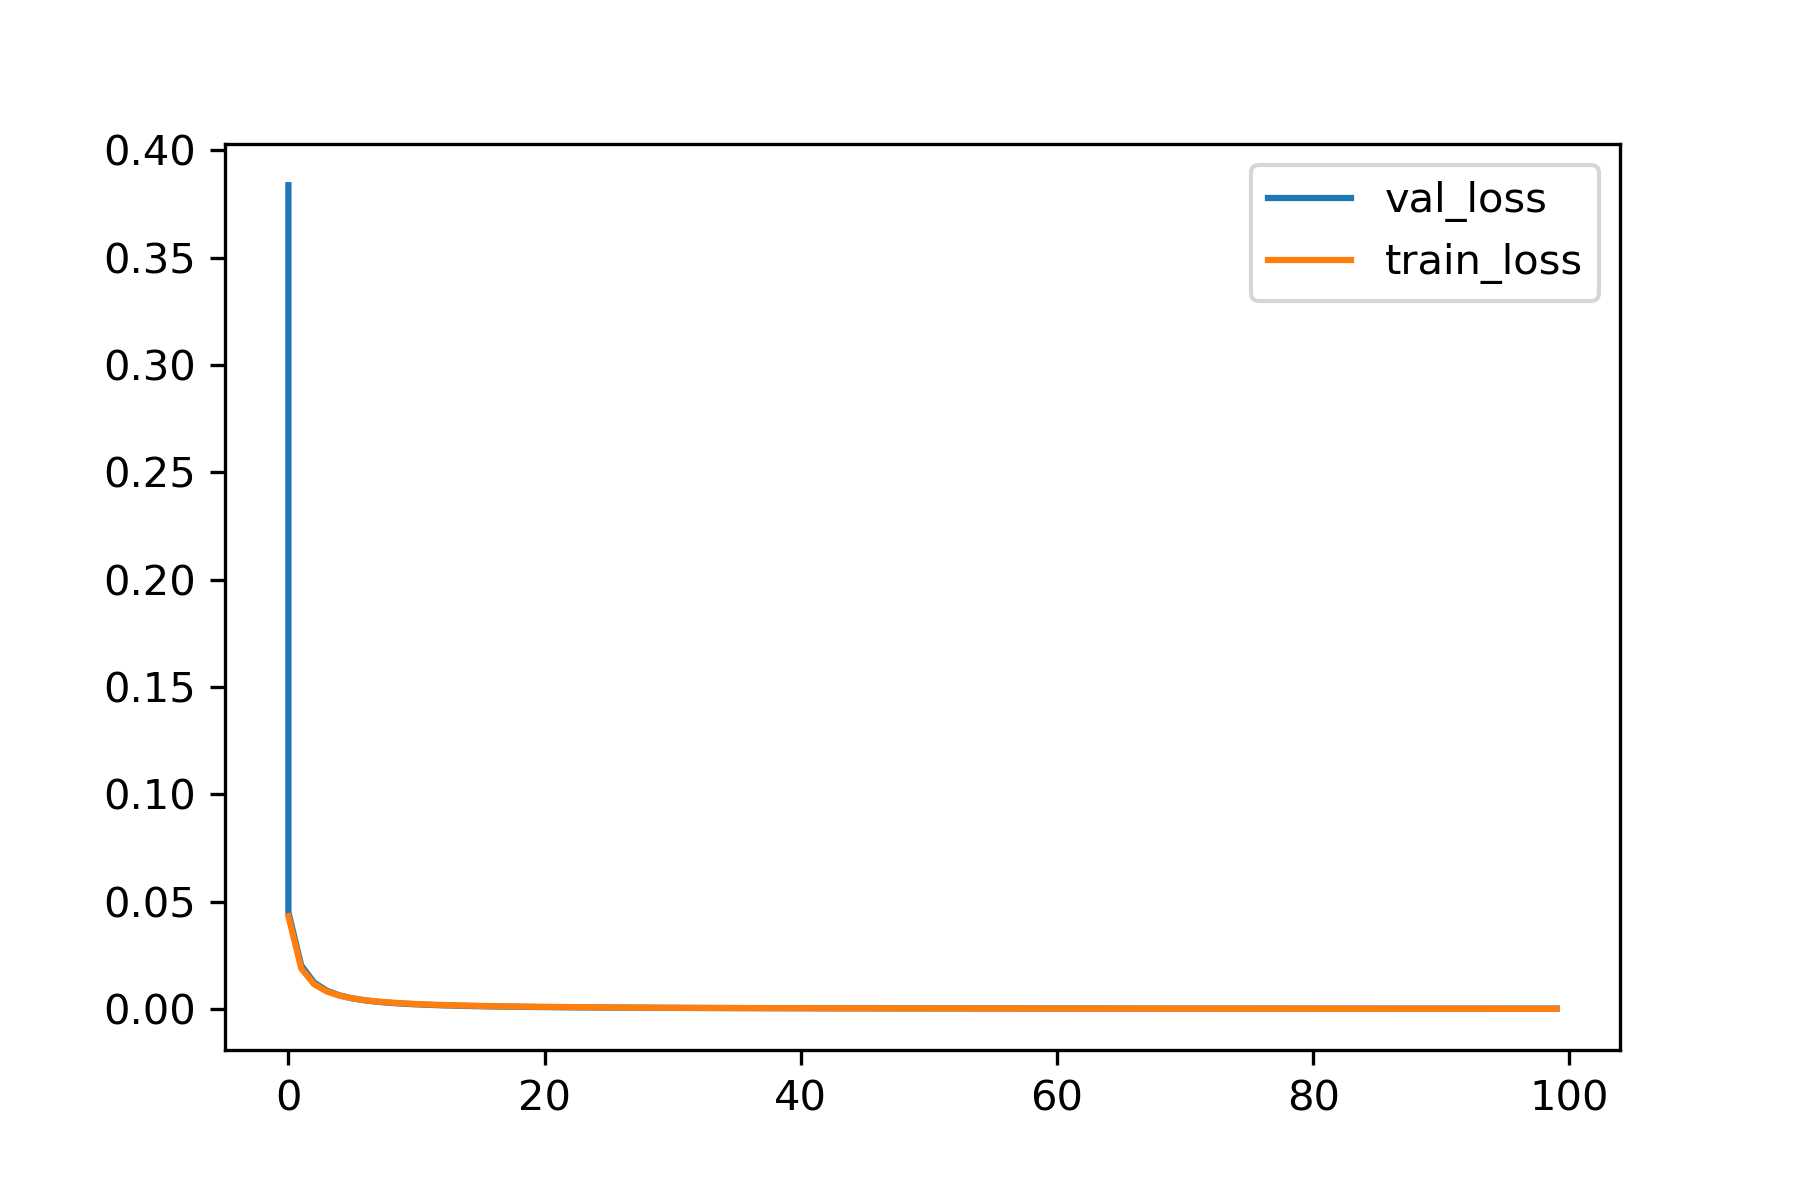

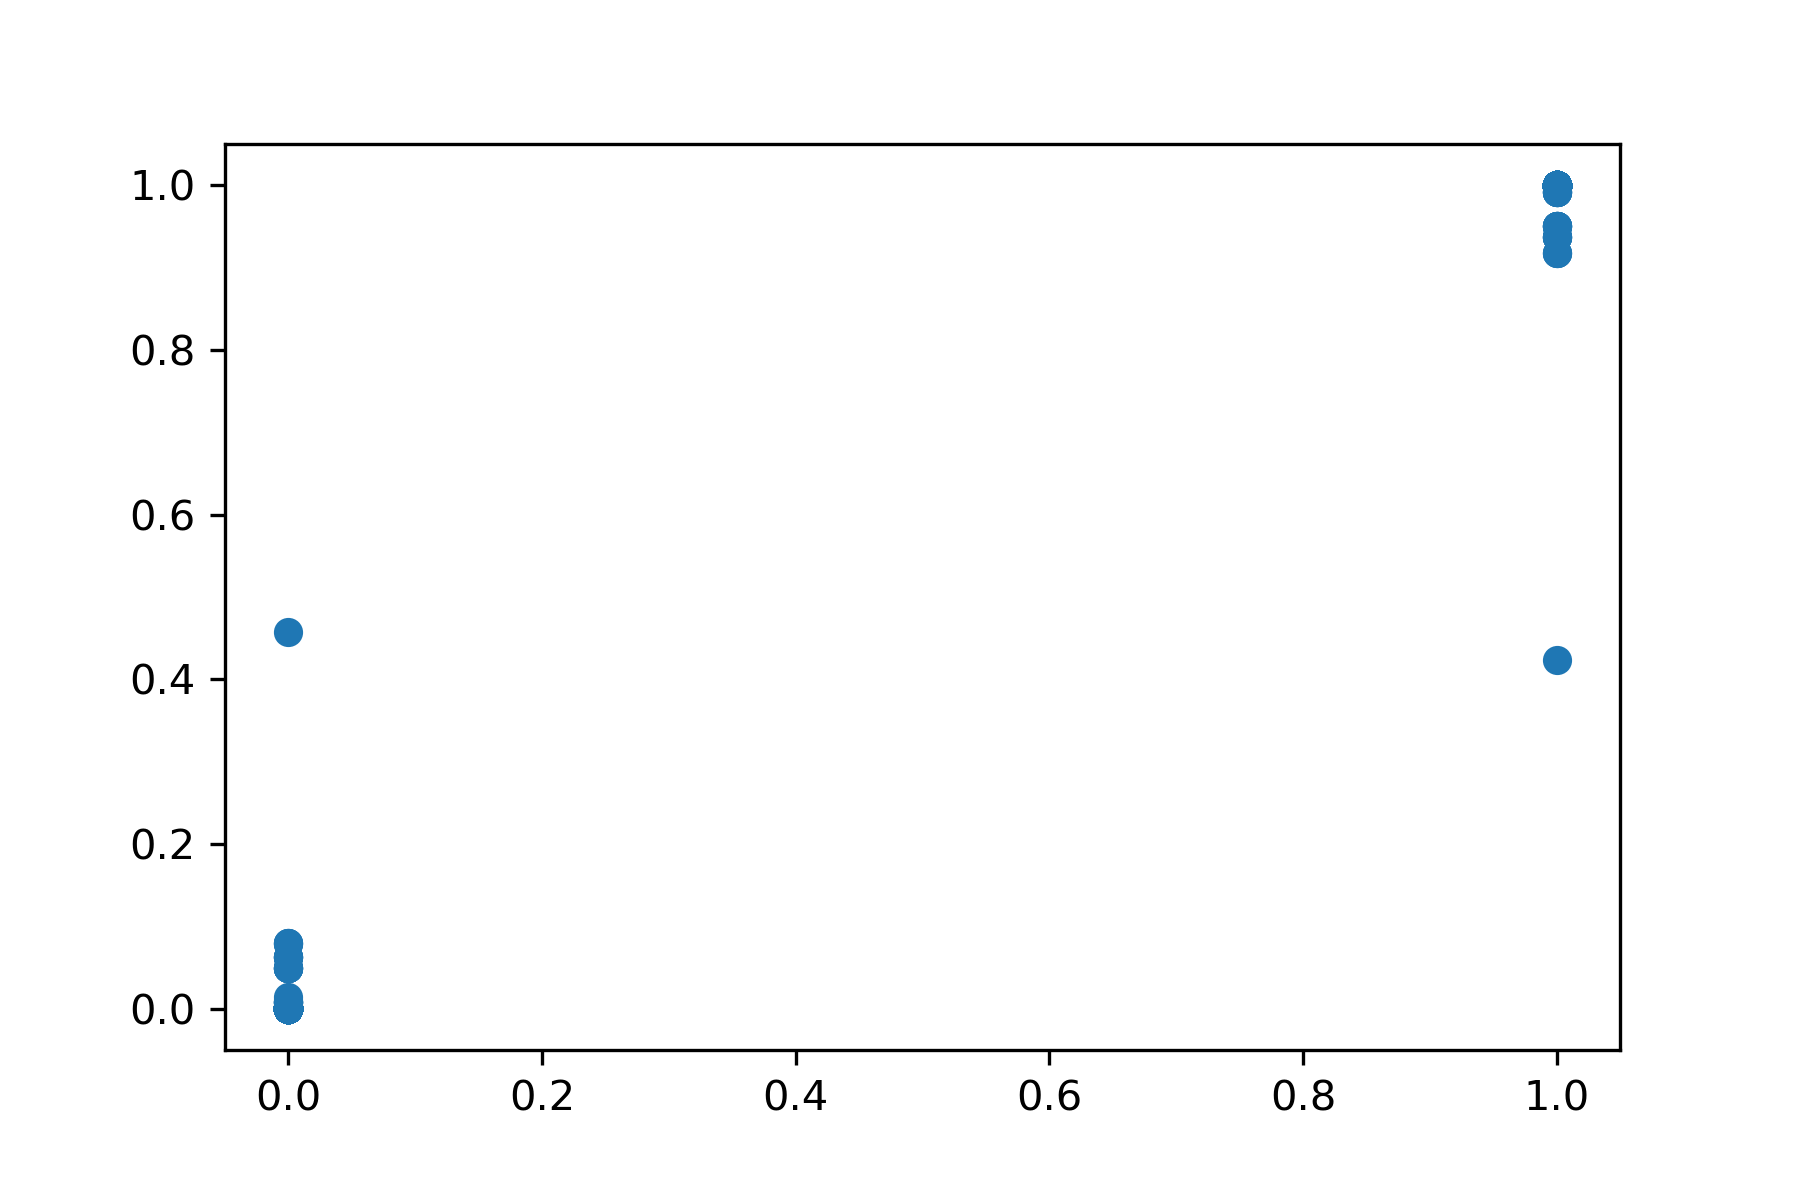

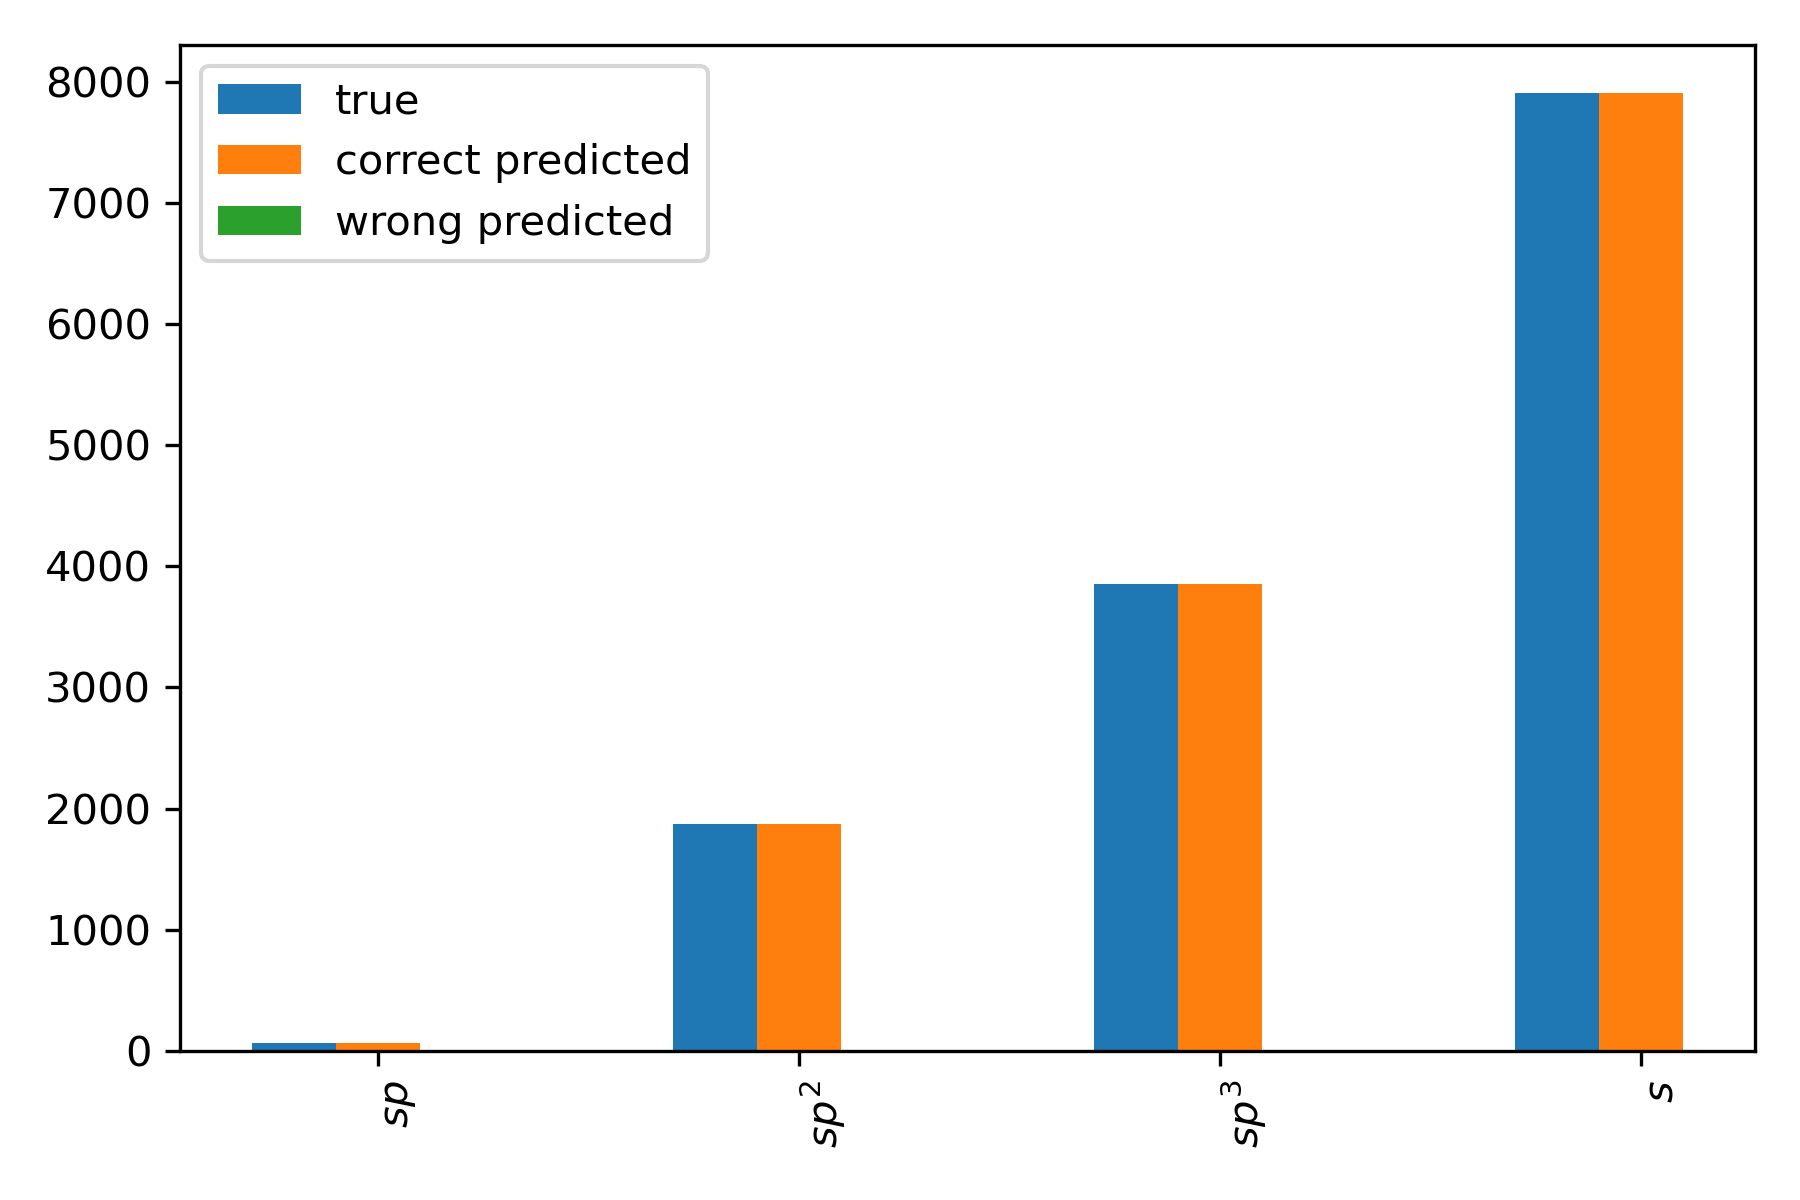

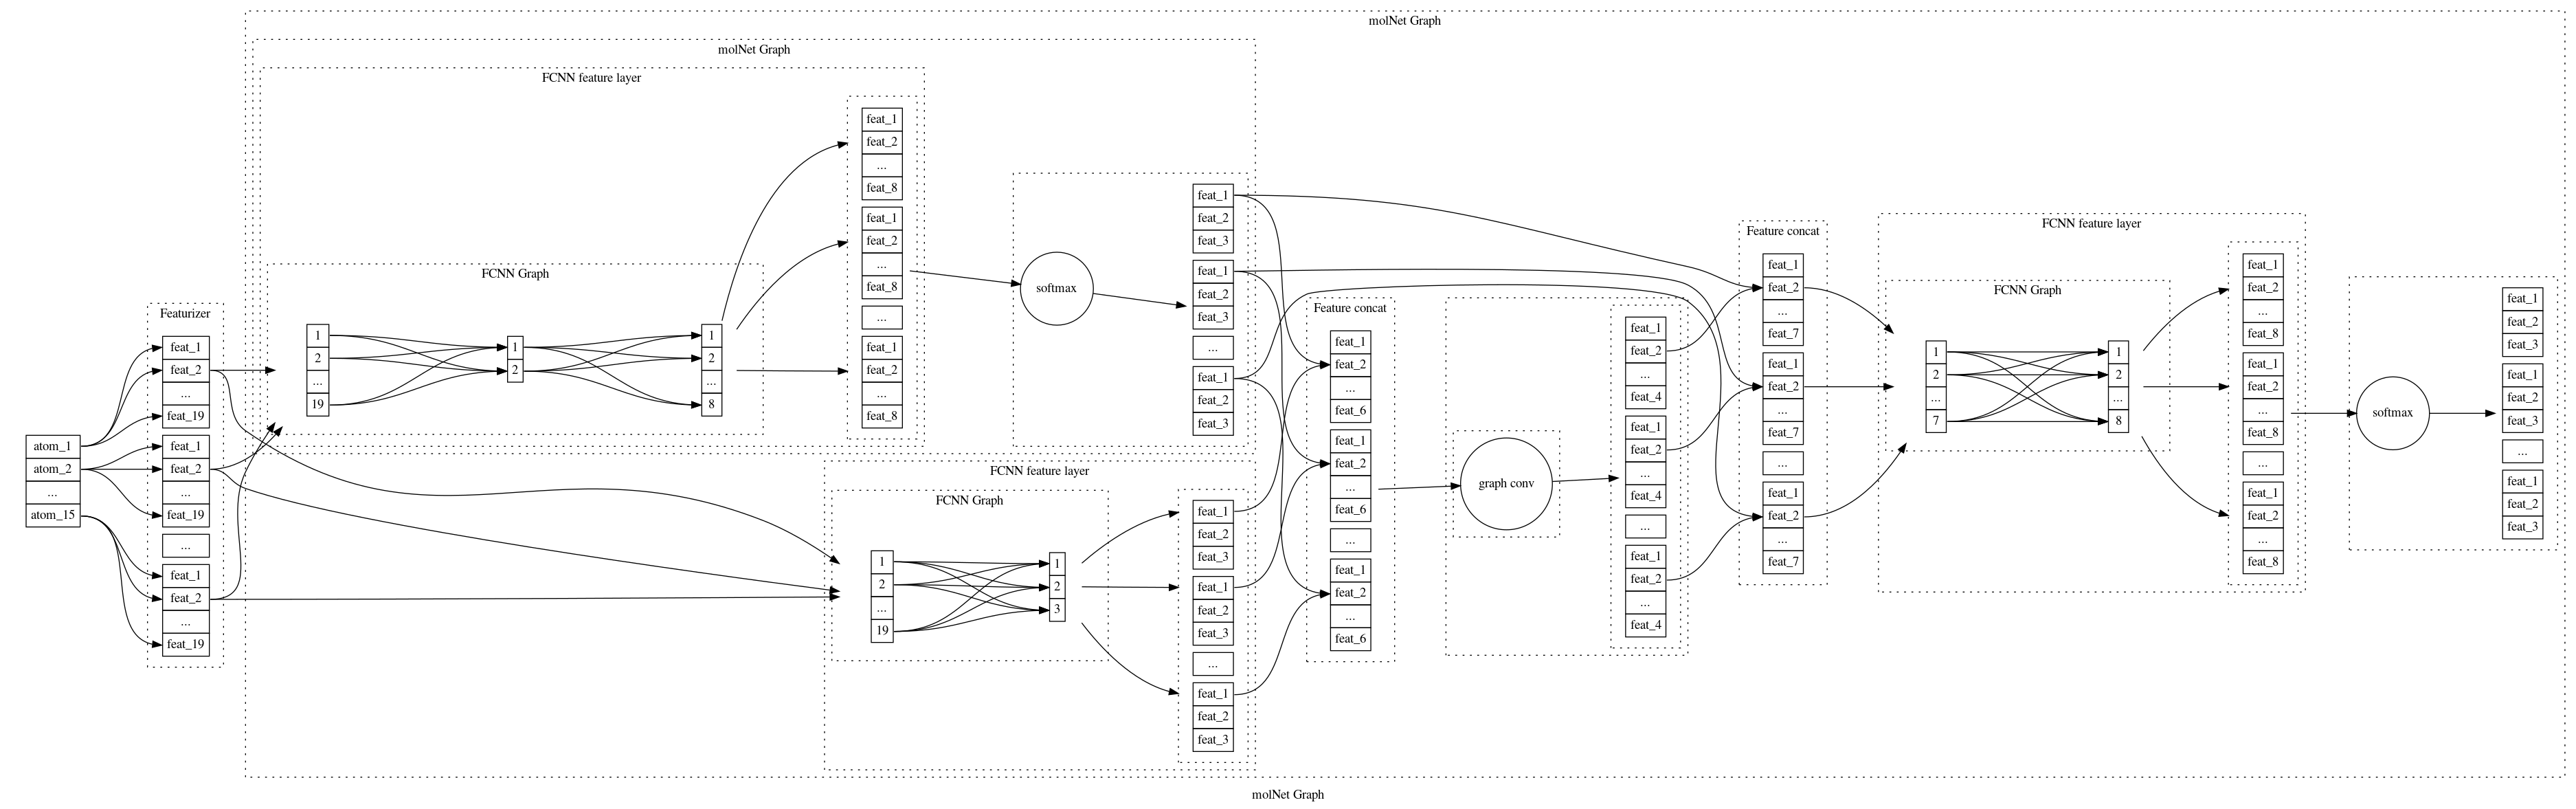

In [251]:
featurizer=c_atom_symbol_featurizer+atom_degree_one_hot


    
class HybridizationFromTypeGCModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        
        #predict self 
        #self.nn1 = torch.nn.Linear(in_size, 2,bias=False)
        #self.nn2 = torch.nn.Linear(self.nn1.out_features, len(atom_hybridization_one_hot),bias=False)
        
        self.nn3 = torch.nn.Linear(in_size, 3,bias=False)
        
        
        self.gc1 = GCNConv(len(atom_hybridization_one_hot)+self.nn3.out_features,4,# self.nn2.out_features
                           #+self.nn3.out_features
                           bias=False
                          )
        
        
        self.nnout = torch.nn.Linear(len(atom_hybridization_one_hot)+self.gc1.out_channels,len(atom_hybridization_one_hot),bias=False)
               
        
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.lr = 1e-2
        
        self.lossf=F.binary_cross_entropy#torch.nn.BCEWithLogitsLoss()#

    def unpacked_forward(self, feats, edges, batch,graph_features):
        #f1 = self.nn1(feats)
        #f1 = self.nn2(f1)
        #f1 = self.softmax(f1)   
        if model_HybridizationFromTypeAndDegreeModel.device != feats.device:
            model_HybridizationFromTypeAndDegreeModel.to(feats.device)
        f1 = model_HybridizationFromTypeAndDegreeModel.unpacked_forward(feats, edges, batch,graph_features)
        
        f2= self.nn3(feats)
        
        f = self.gc1(torch.cat([f1,f2], dim=1),edges)
        
        feats = torch.cat([f1,f], dim=1)
        
        feats = self.nnout(feats)
        feats = self.softmax(feats)
        return feats
      
    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        #print(y_hat[0],batch.y[0],loss)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('test_loss', loss)
        return loss
    
    def to_graphviz(self,feature_graph,name,reduced):
        parent=molNetGraphviz(name=name)
        hybridg = model_HybridizationFromTypeAndDegreeModel.to_graphviz(
            feature_graph,reduced=reduced,name=name+"hybridizationfromtypemodel")
        parent.subgraph(hybridg)
        
        fnn3=FeatureNNCombiGraph(feature_graph,n_output=self.nn3.out_features,name="nn3")
        parent.subgraph(fnn3)
        
        fcg=FeatureCatGraph([fnn3.feature_graph,hybridg.output],name="cat1")
        parent.subgraph(fcg)
        
        gc1g=GraphConvGraph(fcg,f_out=self.gc1.out_channels,name="gcnn")
        parent.subgraph(gc1g)
        
        fcg2=FeatureCatGraph([hybridg.output,gc1g.feature_graph],name="cat2")
        parent.subgraph(fcg2)
        
        nnoutg=FeatureNNCombiGraph(fcg2,n_output=self.nnout.out_features,name="nnout")
        parent.subgraph(nnoutg)
        
        nnoutg_sm=FeatureGraph(frn.feature_graph.features,frn.feature_graph.items,
                   parent=frn.feature_graph, name=name+"_sm")
        parent.subgraph(nnoutg_sm)

        sm = FunctionCall("softmax",nnoutg.feature_graph.node_name,nnoutg_sm.node_name,name=name+"_sm",)
        parent.subgraph(sm)
        
        
        #feats = self.nnout(feats)
        #feats = self.softmax(feats)
        #return feats
    
        return parent
        
        
    def to_graphviz_from_batch(self,batch=None,reduced=False,name=None):
        if name is None:
            name=self.__class__.__name__
        if batch is None:
            features=4
            mol=None
        else:
            mol = batch.to_data_list()[0]
            features=mol.x.shape[1]
        
        parent=molNetGraphviz(name=name)
        
        aig = AtomInputGraph(name=name+"_atom_ip",reduced=True)
        parent.subgraph(aig)

        fg = FeaturizerGraph(aig,features,name=name+"_featurize")
        parent.subgraph(fg)
        
        maing = self.to_graphviz(fg,name=name+"_mg",reduced=reduced)
        parent.subgraph(maing)
        
        return parent
            
loader_HybridizationFromTypeGCModel = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                     y_properties=["hybridization"],
                                     seed=1,
                                     to_graph_params={
                                         "atom_featurizer":featurizer,
                                         "with_mol_graph":True
                                     },
                                    batch_size=32,#num_workers=4
                                    follow_batch=["y"]
                                    )

model_HybridizationFromTypeGCModel = HybridizationFromTypeGCModel(in_size=len(featurizer))

short_hybrid = np.array(["$"+s.split()[1].lower().replace("2","^2").replace("3","^3")+"$" for s in atom_hybridization_one_hot.describe_features()])


model_HybridizationFromTypeGCModel,data_HybridizationFromTypeGCModel = default_model_run(
    "HybridizationFromTypeGCModel",
    model_HybridizationFromTypeGCModel,
    loader_HybridizationFromTypeGCModel,
                  force_run=REMODEL,
                  #force_test_data_reload=True,
                #min_epochs=25,
                               early_stopping=False,
                               max_epochs=100,
                               detect_lr=False,
                categories=short_hybrid.tolist(),
)


The prediction of this model are much better.
To explain the model into detail a closer look to the individual parts has to be made:
After featurizaion the inital veature vectorse are feed into two different layers in parallel. The first one is exactly the previous model, meaning this part calculates the hybridization based somly on type and degree.
The second layer is a simple single layered neuronal network which creates reduces the features via a linear combination from the initial 19 to 3:

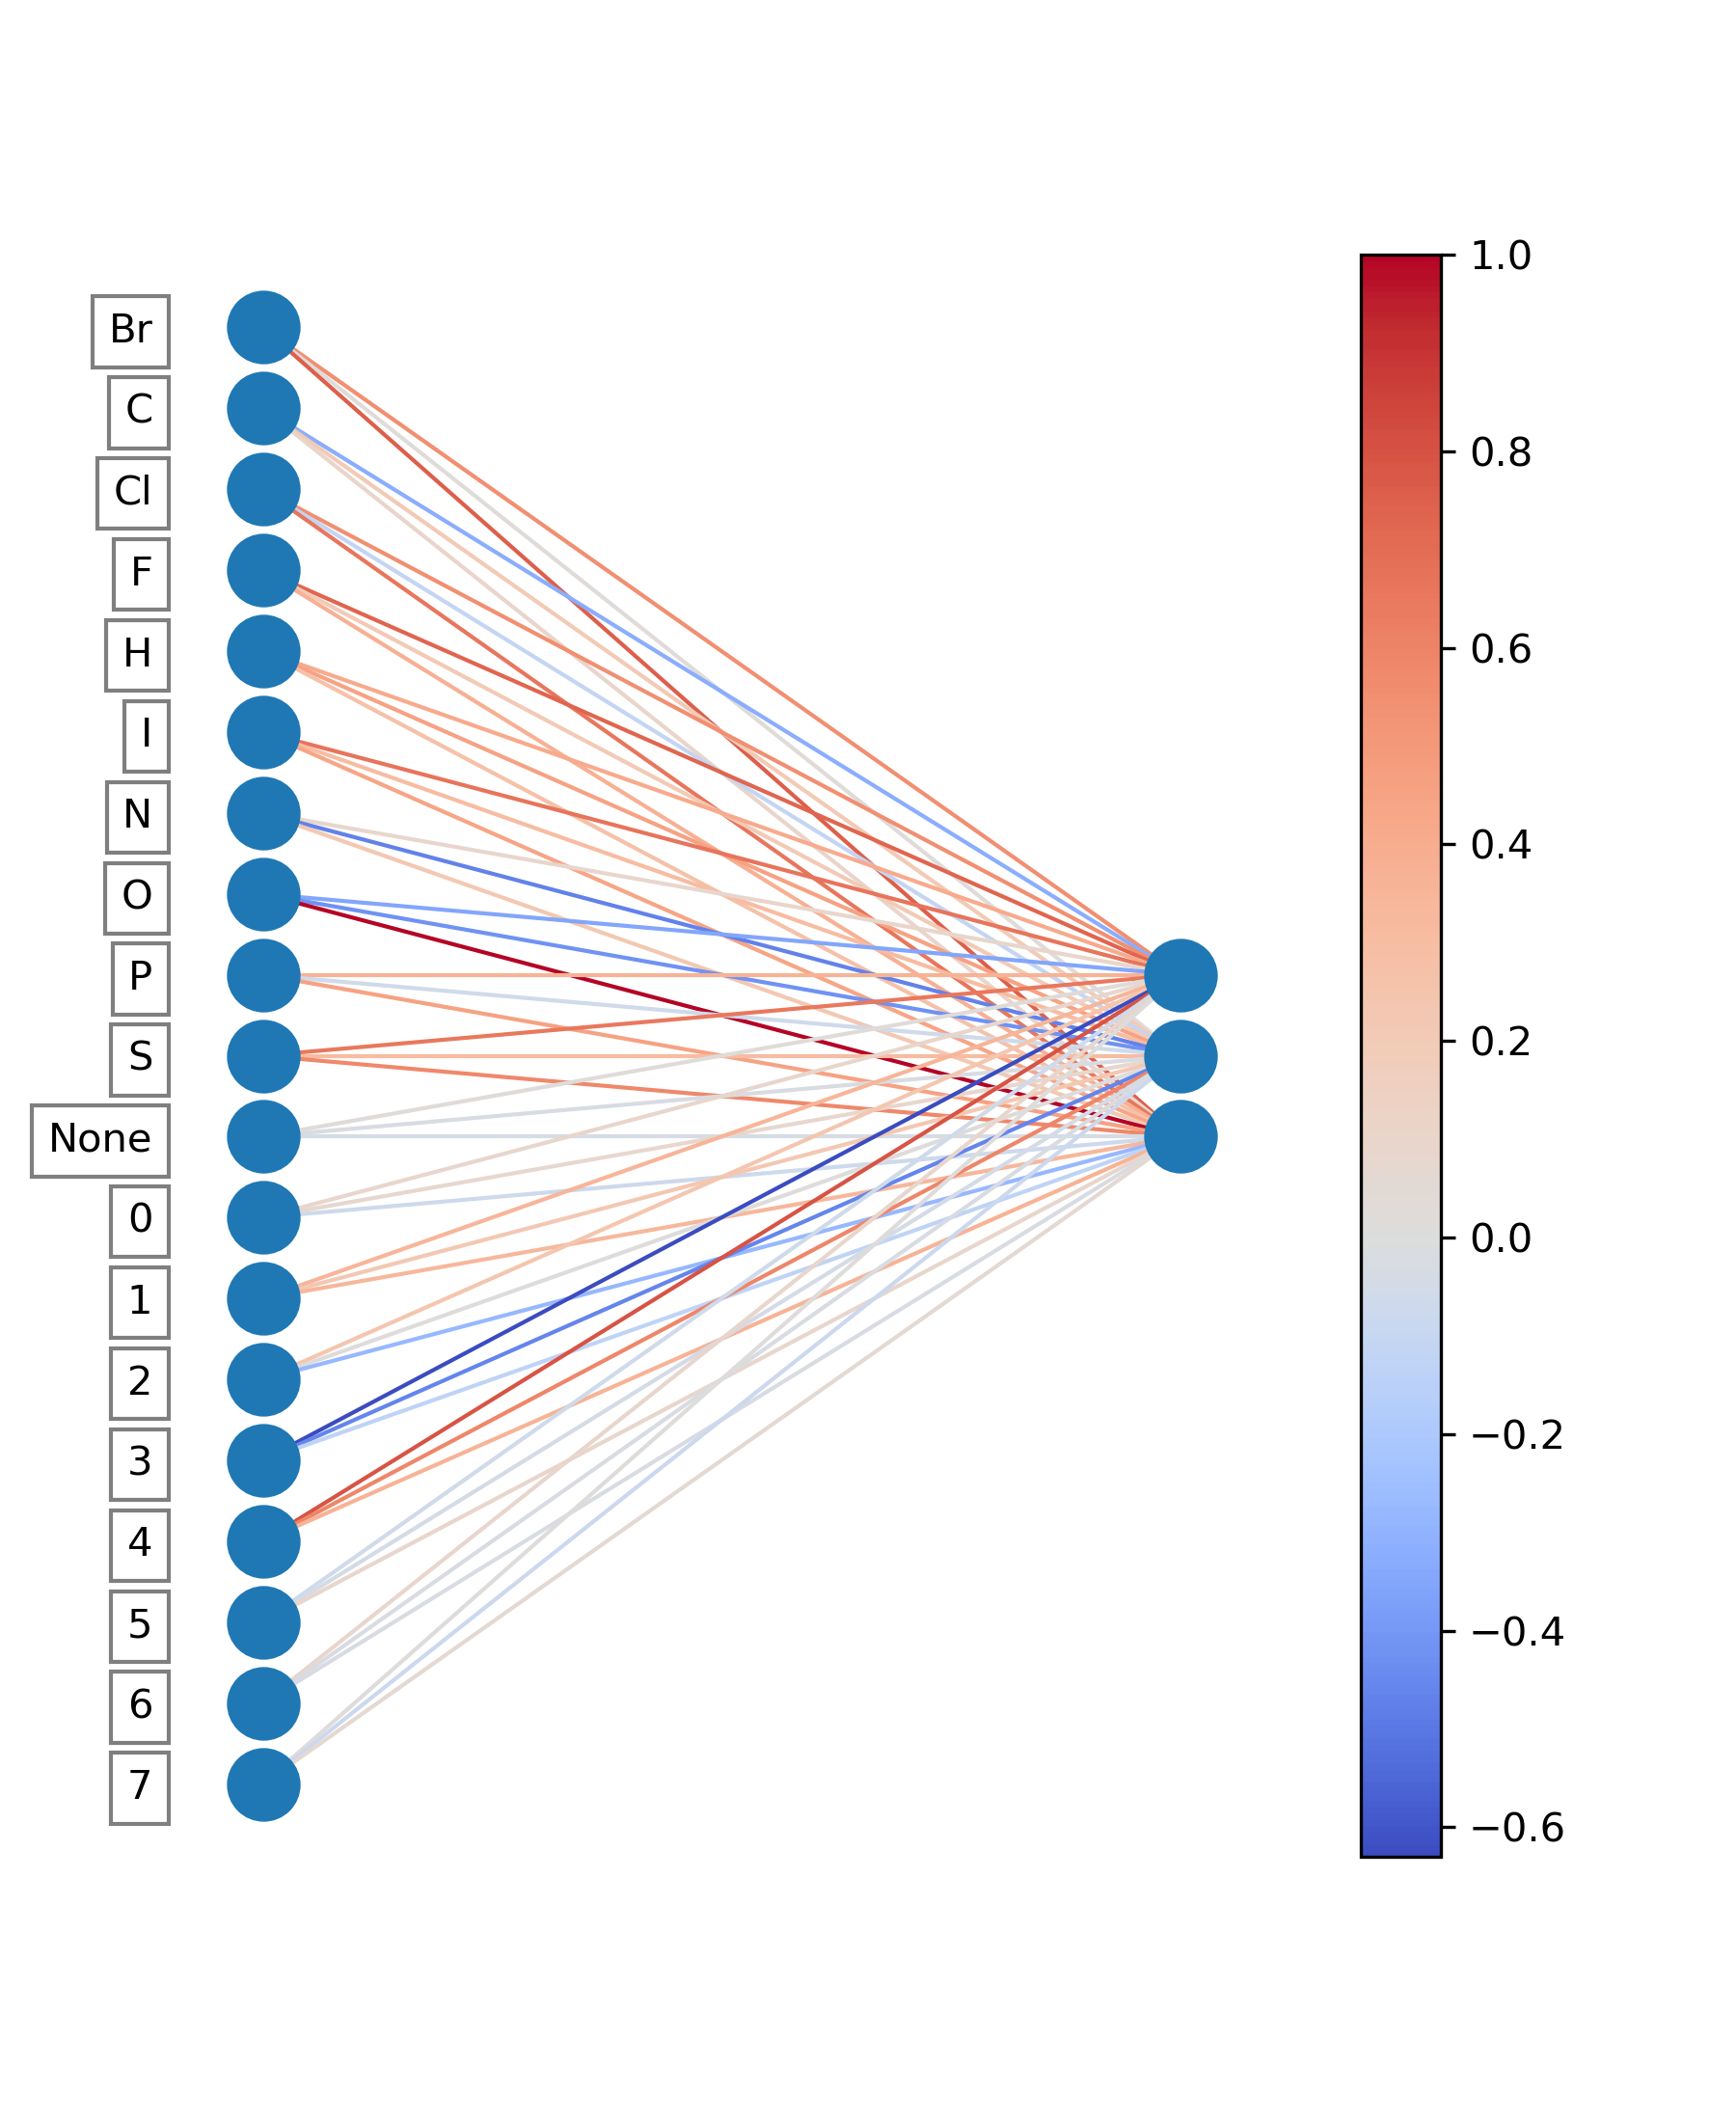

In [252]:
worked=[]
w3=model_HybridizationFromTypeGCModel.nn3.weight.detach().numpy().copy()
w3[np.abs(w3)<0.]=0
sf=os.path.join(data_HybridizationFromTypeGCModel["files"]['plot_dir'],"full_nn_layer.png")
plot_fcnn([len(loader_HybridizationFromTypeGCModel.to_graph_params['atom_featurizer']),
           w3.shape[0]
          ],
          weights=[w3],
          input_labels=[s.split(": ")[1] for s in loader_HybridizationFromTypeGCModel.to_graph_params['atom_featurizer'].describe_features()]+
          [None]*w3.shape[0]+[None]*w3.shape[1],
              hide_loose=True,
              show_bar=True,
            save=sf,
          layer_norm=True,
                 )
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))

Considering that previous predictions where mainly wrong because of heteroatoms, who's non-binding electrons are integrated in a delocalized system, it's obvious that the subnetwork has to detect possible atoms which might be able to be integrated into an delocalized system and in direct contact with these heteroatoms.
Given the natural occururance in organic chemistry (and espacially in the used training data) these atoms are
mainly: Oxigen with a single partner (e.g. from carbonyles) , Nitrogen (e.g. amides)  and Carbon with 3 bonding partners (aromates) are "detected" by this sub network.
This can also be oberved when looking on the output of the network for the example molecule (1 representation per feature):

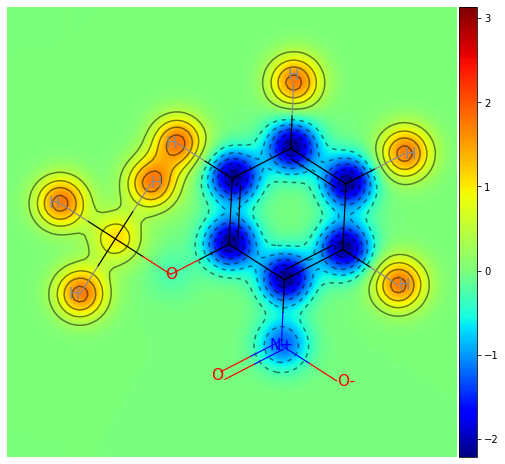

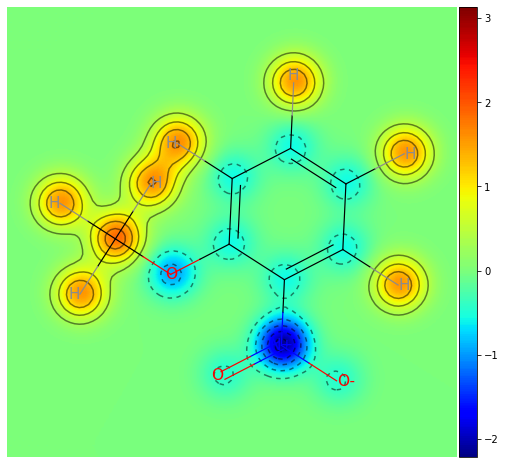

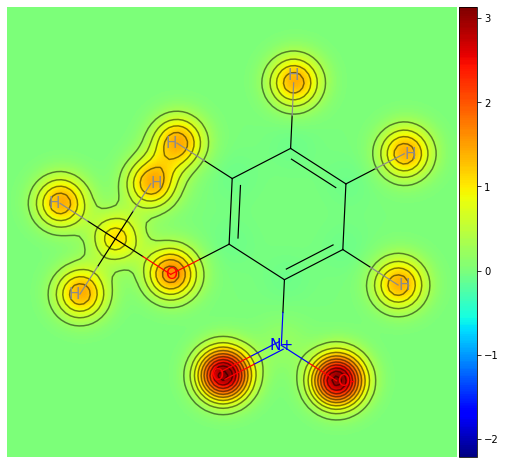

In [255]:
from rdkit.Chem.Draw import SimilarityMaps
from scipy import signal

import rdkit.Chem.Draw as Draw
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

mol=data_HybridizationFromTypeGCModel["test_data"].mol_graph.mol
feats=data_HybridizationFromTypeGCModel["test_batch"].x
contribs = model_HybridizationFromTypeGCModel.nn3(feats).detach().numpy()
#contribs=np.abs(contribs).max()

plot_features_to_mol(contribs)

In [254]:
#display(mol)
#rdkit.Chem.Draw.MolToMPL(mol.mol)
#plt.show()
#plt.close()
for d in range(contribs.shape[1]):

    res=0.001
    kernlen=int(0.3/res)
    std=50

    pos=np.array([p for p in mol.calc_position().values()])

    x1d = np.arange(pos[:,1].min()-(kernlen+1)*res, pos[:,1].max()+(kernlen+1)*res, res)
    x2d = np.arange(pos[:,0].min()-(kernlen+1)*res, pos[:,0].max()+(kernlen+1)*res, res)
    pos_idx=[[np.abs(x1d-p[1]).argmin(),
             np.abs(x2d-p[0]).argmin()
             ] for p in pos]
    #display(pos_idx)

    x1, x2 = np.meshgrid(x1d, x2d)
    pdf = np.zeros_like(x1)


    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)

    for i,p in enumerate(pos_idx):
        #print(int(p[0]-kernlen/2),int(p[0]-kernlen/2)+kernlen,
        #    int(p[1]-kernlen/2),int(p[1]-kernlen/2)+kernlen)
        #print(pdf[
        #    int(p[0]-kernlen/2):int(p[0]-kernlen/2)+kernlen,
        #    int(p[1]-kernlen/2):int(p[1]-kernlen/2)+kernlen
        #].shape,pdf.shape)
        pdf[
            int(p[0]-kernlen/2):int(p[0]-kernlen/2)+kernlen,
            int(p[1]-kernlen/2):int(p[1]-kernlen/2)+kernlen
        ]+=gkern2d*contribs[i,d]

    plt.contourf(x1, x2,pdf,levels=30)
    
    plt.show()
    plt.close()
    
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol.mol,contribs[:,d], colorMap='jet', contourLines=10)
    plt.colorbar(fig.axes.ravel().tolist())
    plt.show()
    plt.close()
    

AttributeError: 'Mol' object has no attribute 'calc_position'

# for i in range(contribs.shape[1]):
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs[:,i], colorMap='jet', contourLines=10)
#contribs

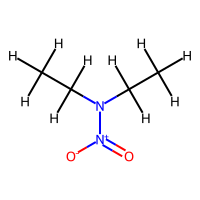

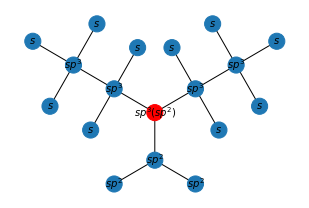

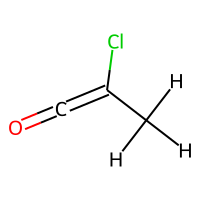

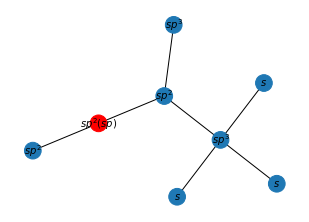

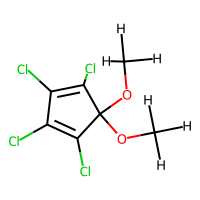

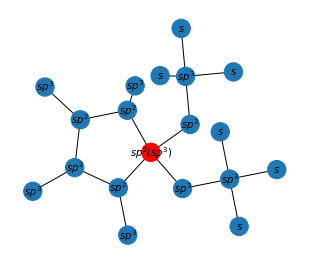

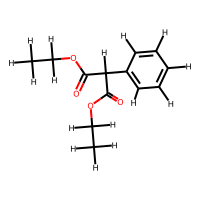

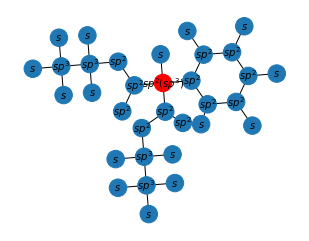

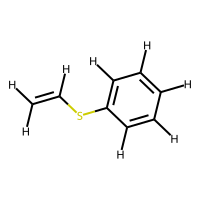

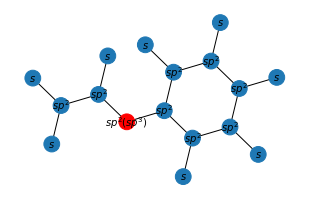

In [10]:
try:
    loader_HybridizationFromTypeGCModel.test_dataloader()
except:
    loader_HybridizationFromTypeGCModel.setup()
    

subgroups=[
           #('[N:1]N(=O)[O-]',"blah"),#nitramines
          ]
sgd=[]
for s,desc in subgroups:
    ind_map = {}
    qmol = Chem.MolFromSmarts(s) 
    for atom in qmol.GetAtoms() :
        map_num = atom.GetAtomMapNum()
        if map_num:
            ind_map[map_num-1] = atom.GetIdx()
    map_list = np.array([ind_map[x] for x in sorted(ind_map)])
    sgd.append((qmol,map_list,desc))
    
loader_names=("test","val","train")
for i,_loader in enumerate([loader_HybridizationFromTypeGCModel.test_dataloader(),loader_HybridizationFromTypeGCModel.val_dataloader(),loader_HybridizationFromTypeGCModel.train_dataloader()]):
    for d in _loader:
        pred=model_HybridizationFromTypeGCModel(d)
        bad_pred=pred.argmax(1)!=d.y.argmax(1)
        for batch in d.batch[bad_pred].unique():
            indices=d.batch == batch
            
            graph=d.mol_graph[batch]
            l_true = short_hybrid[d.y[indices].detach().numpy().argmax(1)].astype(np.object)
            l_pred = short_hybrid[pred[indices].detach().numpy().argmax(1)].astype(np.object)
            
            
            wrong_l=l_true!=l_pred
            node_color=np.array(['#1f78b4']*len(graph))
            node_color[wrong_l]="red"
            l=l_true.copy()
            l[wrong_l]=l_pred[wrong_l]+"("+l_true[wrong_l]+")"
            
            mol=graph.molecule.mol
            found=False
            for sg in sgd:
                if found:
                    break
                #display(sg[0])
                for match in mol.GetSubstructMatches( sg[0] ):
                    match=np.array(match)
                    ##print(sg[1])
                    mas = match[sg[1]]
                    if any(np.where(wrong_l)[0]==mas):
                        found = True
                        display(graph.molecule)
                        plt.show()
                        plt.close()
                        display(sg[2])
                        break
                        
            if not found:
                display(graph.molecule)
                f = graph.get_fig(labels=l.tolist(),node_color=node_color)
                plt.show()
                plt.close()
                #display(Chem.MolToSmiles(graph.molecule.mol))
            #l = short_hybrid[pred[indices].detach().numpy().argmax(1)].tolist()
            #f = graph.get_fig(labels=l)
            #plt.show()
            #plt.close()

Up until know we've only dealt with predicion based on individual atoms which are complete independend from the bonds beween them. Thus we never had to use graph convoluional models, which are used to transfer features from one node (atom) to a conencted one.

number of atoms in model--why